# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

###### TABLE OF CONTENTS

1. Load data and libraries
2. Data Cleaning
3. Data Exploration
4. Feature Engineering
5. Feature Selection

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.

### Check for nulls in the Text column

In [8]:
df = df[df["Text"].notnull()]
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

# Set temporary dataset size, for quicker processing

In [9]:
dev_data_size = 4000

In [10]:
#start_row = int(800000-(dev_data_size/2))-1
#finish_row = int(800000+(dev_data_size/2))-1
#df_sm = df[start_row:finish_row]
df_sm=df.sample(n=dev_data_size,replace=True)
df_sm.count()

sentiment    4000
ID           4000
Time         4000
none         4000
username     4000
Text         4000
dtype: int64

In [11]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [12]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(["I'll use some friction to get you charged - yay for mr. saunder's class and all my dirty-mindedness ",
       "@edwardboches Okay, it's a deal. Looking forward to seeing your new digs. So far the pics ROCK! Everyone looks so happy  #mullenunbound",
       '@BreakThruGuy LOL, yes..but I always feel it can snow any time of the year here. LOL  Wisdom from many cultures-me, here ',
       'im blates SO cool that go:audio are talking to me on fb  LUSHHHH. &lt;3',
       '@susan_boyle great feature about you on CBS Sunday morning. You sound incredible ',
       'i screwed up my blog codes ', 'last day of school !!! ',
       "My computer won't work  can anyone help?",
       "@yelyahwilliams almost in virginia!  can't wait for you to come here!",
       'Still no #Graze box yet '], dtype=object)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [13]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    # NUMBERS IN THE TEXT DATA
    # The numbers in the data came to light during feature engineering. 
    # I will try different things here.
    
    # A processor-efficient approach, as suggested at:
    # https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    # s = s.translate(None, '0123456789')
    # Well, that totally didn't work.
    
    # From the same link, a more conventional, but less efficient approach:
    
    s = re.sub(r'\d+', '', s)
    
    
    # USERNAMES IN THE DATA
    # Let's see if life gets any cleaner with these removed, or if it just blows stuff up.
    # Using code found at: 
    # https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
    
    s = re.sub('@[^\s]+','',s) 
    
    # Was 4374 for 2000
    # 3593 and 1985
    
    return str(s)

## Observations on the removal of Usernames from data

Running with 2000 rows, Bag of Words came up with 4374 dimensions. This took a dog's age to run through RFE. Applying the removal of usernames (strings beginning with '@') from the text data caused 15 of the 2000 to become null - they were stripped from the dataset. Most significantly, it resulted in a reduction of dimensions at the Bag of Words stage to 3593. While this doesn't appear to enable us to ramp up significantly, it does help.

It is worth noting that there appears to be a bit less gibberish in the selected features after appying this. So, a little quicker, a little cleaner, it's a keeper.

## Create new column in dataframe

In [14]:
df_sm["text_clean"] = ''

# Iterate and clean

In [15]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 1463000
processed: 1549000


### Check results

In [16]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
1105578,4,1971306796,Sat May 30 06:46:55 PDT 2009,NO_QUERY,lizziepatrick,"oi oi everyone hope your all good and having a fab day, i think i need more Tweet followers haha so get your mates adding me please","oi oi everyone hope your all good and having a fab day, i think i need more Tweet followers haha so get your mates adding me please"
638620,0,2234505679,Thu Jun 18 23:10:59 PDT 2009,NO_QUERY,gr8rahul,negative inflation ... no wonder my pay cut is being justified,negative inflation ... no wonder my pay cut is being justified
239770,0,1980693852,Sun May 31 07:25:59 PDT 2009,NO_QUERY,Lady_Saga,Had to mow lawn yesterday with a push mower. I can finally feel my fingertips now. Didn't get a chance to play anything yesterday,Had to mow lawn yesterday with a push mower. I can finally feel my fingertips now. Didn't get a chance to play anything yesterday
48377,0,1677856131,Sat May 02 04:21:10 PDT 2009,NO_QUERY,manicmuso,@theatrix OMG!! Well done u!! I'm still battling away at level 19,OMG!! Well done u!! I'm still battling away at level
1491973,4,2069195688,Sun Jun 07 15:26:11 PDT 2009,NO_QUERY,LisaKCarter,"@jenzavala YAY! I'm going to bed, but I will definitely read them tomorrow during my long break at school. I'm excited!","YAY! I'm going to bed, but I will definitely read them tomorrow during my long break at school. I'm excited!"


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [17]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [18]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [19]:
normalize_corpus = np.vectorize(normalize_document)

In [20]:
df_sm["text_normalized"] = ''

In [21]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 1463000
processed: 1549000


### check results

In [22]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
1105578,4,1971306796,Sat May 30 06:46:55 PDT 2009,NO_QUERY,lizziepatrick,"oi oi everyone hope your all good and having a fab day, i think i need more Tweet followers haha so get your mates adding me please","oi oi everyone hope your all good and having a fab day, i think i need more Tweet followers haha so get your mates adding me please",oi oi everyone hope good fab day think need tweet followers haha get mates adding please
638620,0,2234505679,Thu Jun 18 23:10:59 PDT 2009,NO_QUERY,gr8rahul,negative inflation ... no wonder my pay cut is being justified,negative inflation ... no wonder my pay cut is being justified,negative inflation . wonder pay cut justified
239770,0,1980693852,Sun May 31 07:25:59 PDT 2009,NO_QUERY,Lady_Saga,Had to mow lawn yesterday with a push mower. I can finally feel my fingertips now. Didn't get a chance to play anything yesterday,Had to mow lawn yesterday with a push mower. I can finally feel my fingertips now. Didn't get a chance to play anything yesterday,mow lawn yesterday push mower finally feel fingertips ' get chance play anything yesterday
48377,0,1677856131,Sat May 02 04:21:10 PDT 2009,NO_QUERY,manicmuso,@theatrix OMG!! Well done u!! I'm still battling away at level 19,OMG!! Well done u!! I'm still battling away at level,omg well done u !! ' still battling away level
1491973,4,2069195688,Sun Jun 07 15:26:11 PDT 2009,NO_QUERY,LisaKCarter,"@jenzavala YAY! I'm going to bed, but I will definitely read them tomorrow during my long break at school. I'm excited!","YAY! I'm going to bed, but I will definitely read them tomorrow during my long break at school. I'm excited!","yay im going bed , definitely read tomorrow long break school . ' excited !"
...,...,...,...,...,...,...,...,...
451333,0,2069741410,Sun Jun 07 16:26:31 PDT 2009,NO_QUERY,BoxerBritt,I'm so tired. At least my family thing roxors &lt;3 my uncle and aunt and cousins. miss chris more than ever,I'm so tired. At least my family thing roxors < my uncle and aunt and cousins. miss chris more than ever,im tired least family thing roxors < uncle aunt cousins . miss chris ever
1530055,4,2177701341,Mon Jun 15 06:33:29 PDT 2009,NO_QUERY,wd8,adding friends in Poupee Girl.,adding friends in Poupee Girl.,adding friends poupee girl
102894,0,1795305046,Thu May 14 07:32:04 PDT 2009,NO_QUERY,WebTrawler,@michelletripp Don't be too bummed. Saw it @ IMAX Sydney (largest in the world) &amp; felt it was too big. Action seqs were all a blur to me,Don't be too bummed. Saw it @ IMAX Sydney (largest in the world) & felt it was too big. Action seqs were all a blur to me,dont bummed saw @ imax sydney ( largest world ) & felt big . action seqs blur
17829,0,1556411547,Sat Apr 18 22:44:08 PDT 2009,NO_QUERY,CharleneVSmart,"is back in Chch, oh yea!! Now to find a new flat Have to move out, flatties moving in with boyfriend so I have to go ......","is back in Chch, oh yea!! Now to find a new flat Have to move out, flatties moving in with boyfriend so I have to go ......","back chch oh yea ! find new flat move , flatties moving boyfriend go ......"


In [23]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [24]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

1463000
1549000


In [25]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
1105578,4,1971306796,Sat May 30 06:46:55 PDT 2009,NO_QUERY,lizziepatrick,"oi oi everyone hope your all good and having a fab day, i think i need more Tweet followers haha so get your mates adding me please","oi oi everyone hope your all good and having a fab day, i think i need more Tweet followers haha so get your mates adding me please",oi oi everyone hope good fab day think need tweet followers haha get mates adding please,oi oi everyone hope good fab day think need tweet follower haha get mate add please,oi oi good fab day follower mate,tweet,hope think need get add,oi oi good fab day follower mate tweet hope think need get add,16.00
638620,0,2234505679,Thu Jun 18 23:10:59 PDT 2009,NO_QUERY,gr8rahul,negative inflation ... no wonder my pay cut is being justified,negative inflation ... no wonder my pay cut is being justified,negative inflation . wonder pay cut justified,negative inflation . wonder pay cut justify,inflation wonder pay cut,negative,justify,inflation wonder pay cut negative justify,7.00
239770,0,1980693852,Sun May 31 07:25:59 PDT 2009,NO_QUERY,Lady_Saga,Had to mow lawn yesterday with a push mower. I can finally feel my fingertips now. Didn't get a chance to play anything yesterday,Had to mow lawn yesterday with a push mower. I can finally feel my fingertips now. Didn't get a chance to play anything yesterday,mow lawn yesterday push mower finally feel fingertips ' get chance play anything yesterday,mow lawn yesterday push mower finally feel fingertip ' get chance play anything yesterday,mow lawn yesterday mower fingertip chance yesterday,,push feel play,mow lawn yesterday mower fingertip chance yesterday push feel play,14.00
48377,0,1677856131,Sat May 02 04:21:10 PDT 2009,NO_QUERY,manicmuso,@theatrix OMG!! Well done u!! I'm still battling away at level 19,OMG!! Well done u!! I'm still battling away at level,omg well done u !! ' still battling away level,omg well do u ! ! ' still battle away level,u level,,omg do battle,u level omg do battle,11.00
1491973,4,2069195688,Sun Jun 07 15:26:11 PDT 2009,NO_QUERY,LisaKCarter,"@jenzavala YAY! I'm going to bed, but I will definitely read them tomorrow during my long break at school. I'm excited!","YAY! I'm going to bed, but I will definitely read them tomorrow during my long break at school. I'm excited!","yay im going bed , definitely read tomorrow long break school . ' excited !","yay -PRON- be go bed , definitely read tomorrow long break school . ' excited !",yay bed tomorrow break school,long excited,be go read,yay bed tomorrow break school long excited be go read,16.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451333,0,2069741410,Sun Jun 07 16:26:31 PDT 2009,NO_QUERY,BoxerBritt,I'm so tired. At least my family thing roxors &lt;3 my uncle and aunt and cousins. miss chris more than ever,I'm so tired. At least my family thing roxors < my uncle and aunt and cousins. miss chris more than ever,im tired least family thing roxors < uncle aunt cousins . miss chris ever,-PRON- be tire least family thing roxor < uncle aunt cousins . miss chris ever,family thing roxor uncle aunt cousins miss chris,least,be tire,family thing roxor uncle aunt cousins miss chris least be tire,15.00
1530055,4,2177701341,Mon Jun 15 06:33:29 PDT 2009,NO_QUERY,wd8,adding friends in Poupee Girl.,adding friends in Poupee Girl.,adding friends poupee girl,add friend poupee girl,friend poupee girl,,add,friend poupee girl add,4.00
102894,0,1795305046,Thu May 14 07:32:04 PDT 2009,NO_QUERY,WebTrawler,@michelletripp Don't be too bummed. Saw it @ IMAX Sydney (largest in the world) &amp; felt it was too big. Action seqs were all a blur to me,Don't be too bummed. Saw it @ IMAX Sydney (largest in the world) & felt it was too big. Action seqs were all a blur to me,dont bummed saw @ imax sydney ( largest world ) & felt big . action seqs blur,do not bummed see @ imax syd

# Sometimes, our cleaning reduces our text to nothing! Which makes a lot of stuff unable to run.

## This hack has been helpful in that regard:

In [26]:
# Save in case we need it later:


df_sm = df_sm[df_sm["text_nav"].notnull()]
df_sm.count()

# shuffle the dataset for later.
# df = df.sample(frac=1)

sentiment          3983
ID                 3983
Time               3983
none               3983
username           3983
Text               3983
text_clean         3983
text_normalized    3983
text_lemma         3983
text_nouns         3983
text_adjectives    3983
text_verbs         3983
text_nav           3983
no_tokens          3983
dtype: int64

----------------------------------------

# Saving Cleaned Data to the Filesystem

### So I can run without re-cleaning, or move a chunk to the Cloud for experiments.

In [27]:
# save cleaned data

df_sm.to_csv('cleaned01.csv', encoding='utf-8', index=False)

# Loading Cleaned Data from the Filesystem

### Saved in various sizes, load as appropriate

In [28]:
# df_sm = pd.read_csv("s140_cln_100k.csv", encoding="utf-8")

## s140_cln_100k.csv

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [29]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [30]:
df_sm['sentiment'].value_counts()

0    2013
4    1970
Name: sentiment, dtype: int64

Good. Seems balanced enough for now.

### Show data types in each column

In [31]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [32]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,3983.00,1.98,2.00,0.00,0.00,0.00,4.00,4.00
ID,3983.00,1993686319.87,194506176.26,1467824647.00,1932569462.50,2001436746.00,2175834108.50,2329150157.00
no_tokens,3983.00,8.73,5.37,1.00,5.00,8.00,12.00,54.00


### Exploring text at different levels of cleaning

In [33]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
1371261,u will conquer the smallest venue with ur nice voice easily!,u conquer smallest venue ur nice voice easily,u conquer small venue ur nice voice easily,conquer venue ur voice small nice
438573,"O, my dear, ty so much that. Always rt on time. Just mom & I again. Niece couldn't tke it, i guess. I needed tht shtout!","dear ty much . always rt time . mom & . niece ' tke , guess . needed tht shtout !","dear ty much . always rt time . mom & . niece ' tke , guess . need tht shtout !",rt time mom niece tht shtout dear guess need
1478642,I did try to figure it out for a few minutes before I cheated...don't think I would have ever figured that one out,try figure minutes cheated . ' think would ever figured one,try figure minute cheat . ' think would ever figure one,figure minute try cheat think would figure
678947,"my left shoulder really hurts, and I have no idea why.",left shoulder really hurts idea,left shoulder really hurt idea,shoulder idea left hurt
1311006,i liked the song I'm definitley buying it!,liked song im definitley buying,liked song -PRON- be definitley buying,liked song definitley buying be
488631,; bad moooooood. Like always.,bad moooooood like always .,bad moooooood like always .,moooooood bad
1489297,"today was fun, the buzz is great, we had freddy krueger chasing us, and sarah ran into a wall haha","today fun buzz great freddy krueger chasing us , sarah ran wall haha","today fun buzz great freddy krueger chase -PRON- , sarah run wall haha",today fun buzz great freddy krueger sarah wall chase run
736088,I feelso ill today.my back and neck is killing me.my feet are hurting.i've got a banging headache.Plus I'm nackered! had mins of sleep!,feelso ill todaymy back neck killing memy feet hurting . ' got banging headache . plus ' nackered ! mins sleep !,feelso ill todaymy back neck kill memy foot hurt . ' get bang headache . plus ' nackere ! min sleep !,ill todaymy neck memy foot headache min sleep kill hurt get bang nackere
890733,You could always submit a few old photos and save a couple for new shots at the end of month. You can enter up to pictures.,could always submit old photos save couple new shots end month enter pictures,could always submit old photo save couple new shot end month enter picture,photo couple shot month picture old new could submit save end enter
1180362,Bought the all that glitters dupe,bought glitters dupe,buy glitters dupe,glitters dupe buy


In [34]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [35]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [36]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [37]:
print(tokens[:200])

['oi', 'oi', 'good', 'fab', 'day', 'follower', 'mate', 'tweet', 'hope', 'think', 'need', 'get', 'add', 'inflation', 'wonder', 'pay', 'cut', 'negative', 'justify', 'mow', 'lawn', 'yesterday', 'mower', 'fingertip', 'chance', 'yesterday', 'push', 'feel', 'play', 'u', 'level', 'omg', 'do', 'battle', 'yay', 'bed', 'tomorrow', 'break', 'school', 'long', 'excited', 'be', 'go', 'read', 'friction', 'yay', 'mr', '.', 'saunder', 'class', 'dirty', 'mindedness', 'ill', 'use', 'get', 'charge', 'deal', 'dig', 'pic', 'rock', 'mullenunbound', 'new', 'happy', 'look', 'see', 'look', 'snow', 'time', 'year', 'wisdom', 'culture', 'many', 'feel', 'goaudio', 'fb', 'lushhhh', 'cool', 'be', 'blate', 'talk', 'feature', 'cbs', 'sunday', 'morning', 'sound', 'great', 'incredible', 'boyle', 'blog', 'code', 'screw', 'day', 'school', 'last', 'computer', 'help', 'will', 'work', 'virginia', 'can', 'wait', 'come', 'box', 'graze', 'sorry', 'hugs', 'ankle', 'hope', 'painful', 'be', 'get', 'bread', 'complete', 'burn', 'game

### Counting Frequencies with a Counter

In [38]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('go', 476),
 ('be', 376),
 ('get', 314),
 ('day', 273),
 ('good', 240),
 ('work', 199),
 ('see', 194),
 ('think', 173),
 ('love', 172),
 ('quot', 164),
 ('time', 163),
 ('today', 156),
 ('know', 151),
 ('make', 148),
 ('want', 135),
 ('miss', 133),
 ('thank', 132),
 ('watch', 123),
 ('can', 121),
 ('need', 116)]

In [39]:
print([t[0] for t in counter.most_common(200)]) 

['go', 'be', 'get', 'day', 'good', 'work', 'see', 'think', 'love', 'quot', 'time', 'today', 'know', 'make', 'want', 'miss', 'thank', 'watch', 'can', 'need', 'come', 's', 'would', 'feel', 'new', 'look', 'tomorrow', 'night', 'lol', 'bad', 'morning', 'wait', 'sleep', 'wish', 'take', 'hope', 'last', 'say', 'u', 'sad', 'fun', 'twitter', 'happy', 'great', 'friend', 'try', 'find', 'thing', 'could', 'people', 'week', 'tonight', 'eat', 'much', 'guy', 'show', 'play', 'weekend', 'bed', 'wanna', 'tweet', 'start', 'way', 'may', 'sorry', 'home', 'have', 'movie', 'leave', 'do', 'school', 'follow', 'let', 'rain', 'awesome', 'little', '#', 'ill', 'big', 'keep', 'tell', 'hear', 'talk', 'suck', 'guess', 'girl', 'birthday', 'nice', 'use', 'cool', 'help', 'phone', 'hurt', 'long', 'year', 'will', 'bit', 'sick', 'stuff', 'pic', 'life', 'game', 'head', 'song', 'hate', 'give', 'mean', 'friday', 'well', 'ready', 'hour', 'live', 'listen', 'old', 'call', 'first', 'party', 'check', 'funny', 'summer', 'amazing', 'h

### Remove stopwords from list of tokens

In [40]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

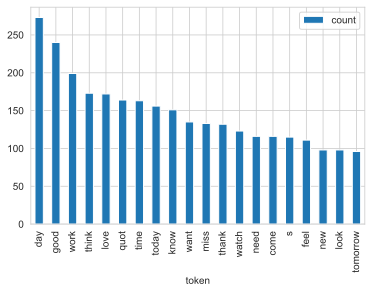

In [41]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

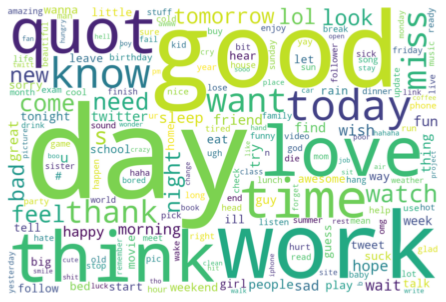

In [44]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

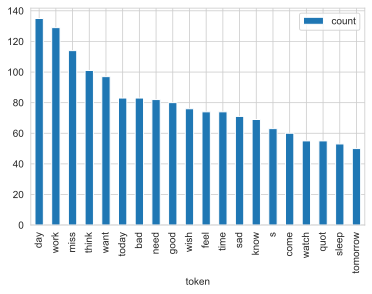

In [45]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

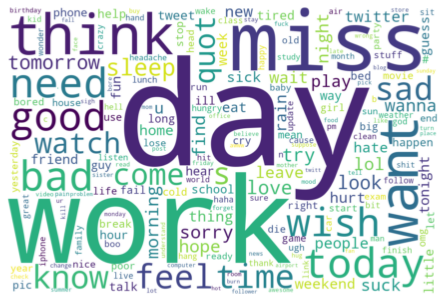

In [46]:
wordcloud(neg_counter)

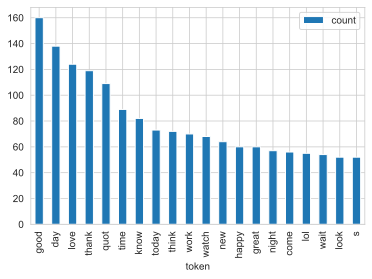

In [47]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

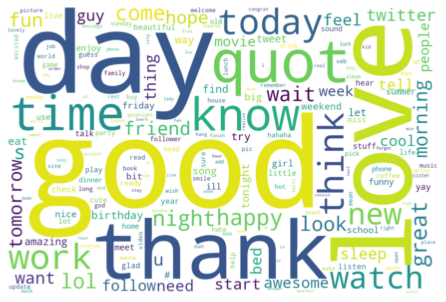

In [48]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [49]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

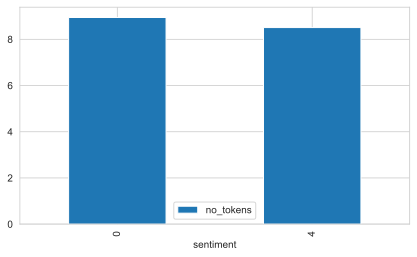

In [50]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [51]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

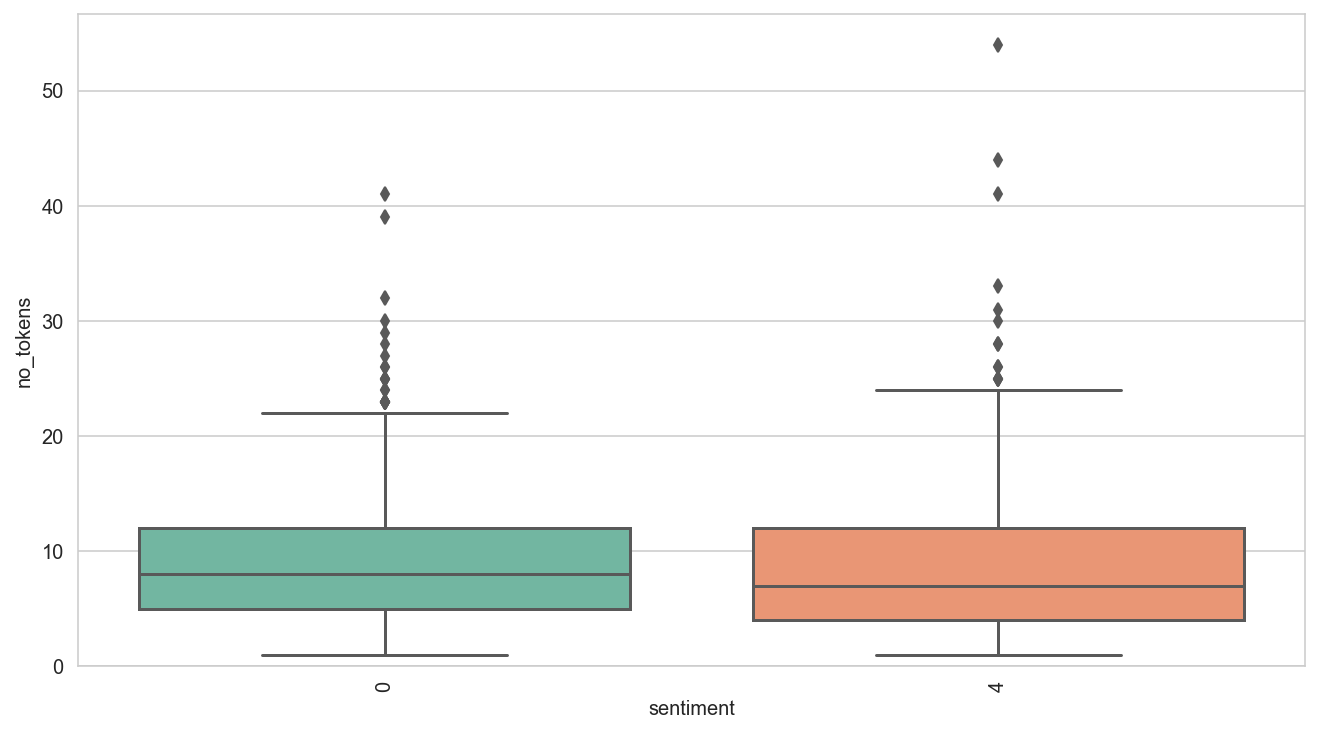

In [52]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [53]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [54]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_nav'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
# get all unique words in the corpus
vocab_bagowords = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab_bagowords)

,aaa,aaaand,aaah,aaahh,aaay,aah,aahh,aand,aannndd,aaron,aarr,aay,ab,abby,abck,...,zzzzzzzz,²à,ºå,½f,½s,½sheesh,æ³,è³¼é,ï¼,ð²ð,ðµ,ðºñ,ð½ð,ð½ñ,ð¾ð
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [57]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       

In [58]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,battle,be,bed,blate,boyle,break,cbs,chance,charge,class,cool,culture,cut,deal,dig,...,saunder,school,see,snow,sound,sunday,talk,time,tomorrow,use,wisdom,wonder,yay,year,yesterday
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
7,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [59]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,5))
bv_matrix = bv.fit_transform(df_sm['text_nav'])

bv_matrix = bv_matrix.toarray()
vocab_ngrams = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab_ngrams)

,aaa yehyehsumpah,aaa yehyehsumpah gk,aaa yehyehsumpah gk enk,aaa yehyehsumpah gk enk angkatan,aaaand awesome,aaaand awesome tired,aaah kid,aaah kid cool,aaah kid cool cute,aaahh fix,aaahh fix ding,aaahh fix ding board,aaahh fix ding board beach,aaahh spot,aaahh spot sinigang,...,ï¼ æ³ è³¼é ï¼ ºå,ð²ð ð½ð,ð²ð ð½ð ð¾ð,ð²ð ð½ð ð¾ð ðµ,ð²ð ð½ð ð¾ð ðµ ð½ñ,ðµ ð½ñ,ðµ ð½ñ ðºñ,ð½ð ð¾ð,ð½ð ð¾ð ðµ,ð½ð ð¾ð ðµ ð½ñ,ð½ð ð¾ð ðµ ð½ñ ðºñ,ð½ñ ðºñ,ð¾ð ðµ,ð¾ð ðµ ð½ñ,ð¾ð ðµ ð½ñ ðºñ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [60]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,be blate,be go,bed tomorrow,blate talk,break school,cbs sunday,chance yesterday,class dirty,cool be,culture many,cut negative,deal dig,dig pic,dirty mindedness,do battle,...,school long,see look,snow time,sound great,sunday morning,time year,tomorrow break,use get,wisdom culture,wonder pay,yay bed,yay mr,year wisdom,yesterday mower,yesterday push
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
7,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_nav'])
tv_matrix = tv_matrix.toarray()

vocab_tfidf = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab_tfidf)

,aaa,aaaand,aaah,aaahh,aaay,aah,aahh,aand,aannndd,aaron,aarr,aay,ab,abby,abck,...,zzzzzzzz,²à,ºå,½f,½s,½sheesh,æ³,è³¼é,ï¼,ð²ð,ðµ,ðºñ,ð½ð,ð½ñ,ð¾ð
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3979,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3980,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3981,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [62]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,battle,be,bed,blate,boyle,break,cbs,chance,charge,class,cool,culture,cut,deal,dig,...,saunder,school,see,snow,sound,sunday,talk,time,tomorrow,use,wisdom,wonder,yay,year,yesterday
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58
2,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.28,0.33,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.28,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.31,0.00,0.00,0.00,0.00,0.00,...,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.26,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.29,...,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.00,0.00,...,0.00,0.00,0.00,0.39,0.00,0.00,0.00,0.39,0.00,0.00,0.39,0.00,0.00,0.39,0.00
7,0.00,0.33,0.00,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.35,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.35,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

## Filter Method

### The scikit-learn library provides the SelectKBest class that uses the chi squared (chi^2) statistical test to select the best features

Our Bag of Words vectorization has provided us with over a thousand features. SelectKBest can identify which of these features are most strongly correlated with our sentiment label. We produce a new Bag of Words containing only the features SelectKBest determines are most important.

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# select the 500 features that have the strongest correlation to a class from the
# original thousands of features
selector = SelectKBest(chi2, k=500)
selected_features = \
bow_selected = selector.fit(cv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features

array([  20,   29,   34,   45,   53,  117,  130,  157,  168,  192,  212,  230,
        267,  272,  295,  314,  345,  349,  359,  360,  376,  380,  401,  438,
        442,  448,  451,  452,  456,  457,  463,  465,  476,  485,  487,  497,
        525,  544,  546,  573,  587,  589,  593,  603,  618,  628,  632,  633,
        636,  663,  674,  694,  709,  758,  760,  763,  769,  773,  802,  818,
        825,  828,  834,  839,  856,  870,  876,  882,  930,  939,  945,  957,
        967, 1017, 1039, 1047, 1078, 1079, 1089, 1095, 1106, 1121, 1122, 1152,
       1178, 1185, 1199, 1206, 1211, 1213, 1235, 1241, 1251, 1252, 1261, 1274,
       1284, 1289, 1291, 1306, 1312, 1317, 1348, 1357, 1369, 1408, 1446, 1462,
       1476, 1501, 1511, 1513, 1517, 1528, 1529, 1540, 1546, 1557, 1567, 1610,
       1611, 1623, 1632, 1636, 1640, 1657, 1663, 1682, 1762, 1774, 1807, 1822,
       1839, 1843, 1849, 1851, 1884, 1885, 1890, 1892, 1910, 1942, 1946, 1947,
       1959, 1965, 1966, 1967, 1975, 1982, 1993, 201

## Interpreting the Selected Features

That array of numbers tells us which indecies of the Bag of Words vectorization were deemed most important by SelectKBest. Kind of boring on its own. It would be much more gratifying to see the actual words it has decided are most important.

## View list of words selected by SelectKBest

In [64]:
for x in selected_features:
    print(vocab_bagowords[x], end=' ')

abt accident ache actor add airport album alright amazing andy annoying api arm arrive assignment attempt awake awesome awwww awwwww back bad balloon bath battery bb bbq bc be beach beat beautiful bed beer begin believe bff birthday bit bliss bloody blue blush bob boo boot bore bored boring brace break brill broken bum bummed bun burn bus cable call camp can cancel candle car carry cat cause character chat check chelsea chi chuckmemonday city clean cnt co coffee cold color comfort comfortable computer congrat connection continue conversation cookie cool cos could course court coz crap crazy create creative cross cruise cry cute daddy damn dead delete dentist desk die dig digital dinner disappear disappoint disgusting disney diversity dnt double doubt draw drink drive drop due dun ear empty enjoy essay evening exact exams excited exciting fabulous face fail fair fantastic feed feel feelin fever field fight figure film find fire flight follow follower followfriday food form france friday

## Wrapper Method

### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=6)
rfe = RFE(model, 500)
fit = rfe.fit(cv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

i=0
for x in fit.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

## More Wrapper Methods

## Bagged Decision Trees - ExtraTreesClassifier classifier class

In [66]:
from sklearn.ensemble import ExtraTreesClassifier

In [67]:
# feature extraction
model_bagged = ExtraTreesClassifier(n_estimators=10)
model_bagged.fit(cv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged.feature_importances_)
# np.set_printoptions(threshold=200)

[0.00e+00 0.00e+00 2.98e-07 ... 4.18e-05 2.07e-04 1.91e-04]


In [68]:
i=0
n=0
min_imp = 0.00041
min_starred = 0.004
for x in model_bagged.feature_importances_:
    if x>min_imp:
        if x>min_starred:
            print('***', end='')
        print(vocab_bagowords[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

afternoon aim airport album amazing andy annoying answer apple apply arrive asian ask ass assignment atleast august awake awesome aww awww awwww awwwww az babe baby back ***bad bath battery bb bbm bbq ***be beach beat beautiful become bed begin bein believe bet big birthday bit bitch blog bloody blue body boo book bore bored boring bother box boy break bro brother bulgarian bum bummed burn busy buy bwinleeey cake call camp ***can cancel car care cat cc change check cheer chillin choose city class clean club code coffee cold colicaaaaaaaaaaaaaaaaaaaaaaabuaaaaaahhhhhh come comfort comment computer confused confusing congrat connection continue cool couch could course cousin cover coz cpu crap crazy cry cute da damn dance ***day deception define dentist die dinner direct disappoint dnt do dog dominos door double doubt download dress drink drive drop dude due ear early eat ebay elephant empty end enjoy enough essay eu evans everytime exam excited exhausted extra eye fail family fan fathers

## Note that the stars ( *** ) denote features that were given much higher importances.

## Feature Selection on TF-IDF encoded features

### Filter Method - SelectKBest

In [69]:
selector_tfidf = SelectKBest(chi2, k=500)
selected_features_tfidf = \
selector_tfidf.fit(tv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_tfidf

array([  20,   29,   34,   45,   62,   79,   92,  117,  130,  145,  157,  163,
        168,  181,  192,  212,  230,  246,  262,  267,  272,  295,  314,  346,
        349,  359,  360,  376,  380,  401,  431,  438,  442,  448,  451,  452,
        456,  457,  463,  465,  476,  485,  487,  497,  518,  525,  544,  546,
        561,  570,  573,  581,  587,  589,  593,  603,  617,  618,  622,  628,
        632,  633,  636,  663,  674,  694,  709,  758,  760,  763,  764,  769,
        802,  825,  828,  834,  856,  870,  876,  880,  882,  885,  889,  930,
        938,  945,  957,  962,  967, 1017, 1047, 1053, 1074, 1078, 1079, 1089,
       1095, 1121, 1122, 1147, 1152, 1174, 1178, 1185, 1199, 1206, 1211, 1213,
       1235, 1241, 1251, 1252, 1261, 1263, 1274, 1284, 1289, 1291, 1306, 1312,
       1317, 1326, 1348, 1357, 1369, 1370, 1408, 1430, 1446, 1449, 1462, 1476,
       1501, 1511, 1513, 1528, 1529, 1536, 1540, 1546, 1567, 1573, 1611, 1623,
       1636, 1637, 1640, 1657, 1682, 1730, 1774, 180

In [70]:
for x in selected_features_tfidf:
    print(vocab_tfidf[x], end=' ')

abt accident ache actor adorable afraid agh airport album allergic alright alton amazing amusing andy annoying api apprentice argentina arm arrive assignment attempt award awesome awwww awwwww back bad balloon base bath battery bb bbq bc be beach beat beautiful bed beer begin believe bet bff birthday bit blame blessing bliss blogtv bloody blue blush bob bonfire boo book boot bore bored boring brace break brill broken bum bummed bun bunch burn cable camp can cancel car carry cat catherine cause cavs cc character chase check chelsea chester chi chuckmemonday clean clever clue cnt co coffee cold comfort comfortable compliment computer confuse congrat connection continue conversation cookie cool cos could course court coz cpu crap crazy create creative cross cruise cry cuddle cute daddy damn damnit dead dee delete deliver dentist desk die dig digital disappear disappoint discover disgusting disney dnt doctor doubt draw drive driver drop due ear elephant enjoy essay evan exact excited excit

## RFE on TF-IDF vectors 

In [71]:
#model_tfidf = LogisticRegression(solver='lbfgs', max_iter=6)
#rfe = RFE(model_tfidf, 500)
#fit_tfidf = rfe.fit(tv_matrix, df_sm['sentiment'])
#print("Num Features: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)

i=0
for x in fit_tfidf.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

# Selecting TF-IDF Features with Bagged Decision Trees

### This represents our most sophisticated feature selection method, being used with our most sophisticated feature engineering method.

Earlier, in the Feature Engineering section, we vectorized our text data using the Term Frequency - Inverse Document Frequency method. This resulted in our documents being represented as vectors with thousands of dimensions. Here we will select the most statistically relevant dimensions using a Wrapper Method known as an Extra Trees Classifier, which is an example of Bagged Decision Trees. 

In [72]:
model_bagged_tfidf = ExtraTreesClassifier(n_estimators=20)
model_bagged_tfidf.fit(tv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_tfidf.feature_importances_)
# np.set_printoptions(threshold=200)

[2.82e-05 0.00e+00 0.00e+00 ... 8.47e-05 2.51e-05 1.14e-04]


In [73]:
tv_matrix_selected = np.array([])
i=0
n=0
min_imp = 0.00020
min_starred = 0.003
#vector_temp = np.array([np.size(tv_matrix, 0)])
#vector_temp.shape = (np.size(tv_matrix, 0),1)
# a = numpy.zeros(shape=(5,2))
vector_temp = np.zeros(shape = ((np.size(tv_matrix, 0)), 1))
np.shape(vector_temp)


(3983, 1)

In [74]:
tv_temp=tv_matrix[:,i]
tv_temp.shape

(3983,)

In [75]:
tv_temp.shape

(3983,)

In [76]:
np.shape(tv_matrix[:,i])

(3983,)

In [77]:
numrows = (np.size(tv_matrix, 0))

In [78]:
for x in model_bagged_tfidf.feature_importances_:
    
    if x>min_imp:
        tv_temp=tv_matrix[:,i]
        tv_temp.shape = (numrows, 1)
        vector_temp=np.append(vector_temp, tv_temp, axis = 1)
        if x>min_starred:
            
            print('***', end='')
        print(vocab_tfidf[i], end=' ')
        n=n+1
    i=i+1
    #vector_temp = np.array([])
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

ab abortion abt accident account add addict afraid afteralll afternoon agh ahh ahhhhhhhh aim air airport album allergic alot amazing andy annoying answer anti apartment app appear apple apply apps arch area arm arrive asian ask asleep ass assignment atleast atreyu attempt august awake awayyyyy awesome awful aww awww awwww awwwww az babe baby back ***bad band bar basketball bath battery bb bbm bbq bc bday ***be beach beat beautiful become bed begin bein believe bella bet big bike bird birthday bit bitch blackberry blech block blog blogtv bloody blue bob body boo book bore bored boring boston bother bout box boy brace brain break breeze bring bro broke broken brother buddy build buildinggggg bulgarian bum bummed bunch burn business busy buy bwhaha bwinleeey cake calendar call camp ***can canberra cancel candidate cape car care cartoon cat catch cause cavs cc cd ceedddrrriiiccc cell certain change chapter character charlotte chase chat check checking cheer chelsea chevy chicken chill chil

In [79]:
np.shape(tv_matrix)

(3983, 6369)

In [80]:
np.size(tv_matrix, 0)

3983

In [81]:
np.shape(vector_temp)

(3983, 1044)

In [82]:
#tv_matrix = vector_temp
vector_temp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
tv_matrix = vector_temp
tv_matrix.shape

(3983, 1044)

# A record and summary of 6 types of Feature Selection

## Because I WILL be dropping RFE for being too intensive.

### Running with 3000 samples gave us vectors with around 5000 dimensions. After much running time, we were able to visually inspect the 500 most important features, as selected by each method. It is perhaps not informative to look at, and compare, these lists of features - but it is fun. And it may give some "subconscious" intuition into that age-old question, "What are these things thinking?" So, before I disable some of these, so I can run bigger datasets through all this code, here's a record of this activity, in the comments/markdown.

I will, quite simple, strip the top two and bottom two rows of each output, and paste them here with clear labels. Pretty sure I won't be running RFE going forward - spins forever, with a pretty low number of samples.

#### SelectKBest with Bag of Words
account actress add age agree ahhh airport amazing american angel animal anne anniversary announce answer appreciate arm arrive attend awesome awful aww awww back bad battle beach beautiful bed bedtime beer believe beloved beyonce birthday blog blonde blue boo book boy boyfriend brand brave britney bro ... tomorrow tongue toooo tragic trust tt tuesday tweet twilight twin twit twitter ugh ughhh unc unfair update updates upgrade upload upset ur use vacuum vegas version voice vote wait walters want warped wat watch way wayne website welcome window wish woke woman wonderful woop work wrist wrong wtf xd xoxo yay young youth yup
#### RFE with Bag of Words
aargh account add addict address afraid age agree ahhh air airport album amazing angel anniversary answer app arm arrive artistic attack attend attention awesome awful awsome aww baby back bad bag battle bc beach bed bet big birthday bit blib blog blue bonjour boo bore bored boy boyfriend brain brand break ... tragic true trust tuesday tv tweeting twin twit twitter ugh unc understand unfair updates upgrade upload upset vacation vegas version vibe video vote wait walmart wanna want wat watch way wayne welcome whole whyyyy wife win wish woke wonder wonderful woop word work working world write wrong wtf xavier xd yay young yup
#### Extra Trees Forest with Bag of Words
able account add addict afraid age agree ahhhh air album alex amazing angel apettite arm art audrey awesome awful aww baby back bad bag battle bc be beach beautiful bed begin beloved big bit blaaaaarg blache blog boo bore boy boyfriend break bubba bug burn bus bye call can cancel cancer car care cat cause ... twitter ugh ughh uncle unfair unusual upgrade upgradeable upload upset upsetting ur use vacation vibe vote wait wake walk wanna want warm warning watch way weather wee week weekend welcome well wholee will wish wishing woke woman wonderful work working world would wrong xoxo yay yeanot year yesterday young yup zoo
#### SelectKBest with TF-IDF
account actress add adore age agree ahaha ahhh airport amazing american anal angel anne anniversary announce annoying answer apologize appreciate arm arrive attend awesome awful awsome aww back background bad bag battle beach beautiful beauty bed bedtime beer beie believe beloved bestie beyonce birthday ... touchy tragic trust tuesday tweetie twilight twin twit twitt twitter ugh ughhh unc uncle understand unfair updates upload upset upsetting use va vegas version view voice vote wait wallpaper want watch way website welcome westney window wish woke woman wonderful woo work wrong xd xoxo yay yayyy young youth yup zoo 
#### RFE with TF-IDF
able account add address afraid age agree ahhh airport album amazing american angel anne anniversary answer appreciate arm arrive art attention awesome awful awsome aww back background bad bag battle bc be beach bed believe big birthday bit blog blue bonjour boo book bore bout boy boyfriend brand brb break bro ... upsetting va vacation vegas version vibe vote wait walk wanna want watch way wee welcome whole window wish wishing woke wonder wonderful word work working world wrong wtf xoxo yay young yud yup zoo
#### Extra Trees Forest with TF-IDF
able actress add addict afraid age agree ahhhh airport alex amazing andrewcilley angel apettite arm art awesome awful aww baby back bad battle bc be beach beautiful bed believe beloved big bit blaaaaarg blache blackberrys blog boo book bore bowls boy boyfriend break brussels bubba bug bunny burn butterfly ... upgrade upgradeable upload upset upsetting ur use vacation vegas vibe video wait wake walk walmart wanna want warm warning watch way weather wee week weekend welcome well whole wholee will window wish wishing woke woman wonderful word work working world worried would wrong xoxo yay yeanot year yesterday young yud yup yuri zoo  



## Last but (maybe) not least - Selecting with our Bag-of-N-Grams

#### Comparing features for Bag-o-words and TF-IDF was very much like comparing apples with apples.

This is going to look a little different, I'll bet, so I'll keep it out from between those two.

In [84]:
# select the 50 features that have the strongest correlation to a class from the
# original thousands of features
selector_ngrams = SelectKBest(chi2, k=400)
selected_features_ngrams = \
ngrams_selected = selector_ngrams.fit(bv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_ngrams

array([  640,   956,   996,  1640,  1832,  2039,  2099,  2190,  2235,  2501,
        2554,  2570,  2646,  3039,  3104,  3126,  3193,  3200,  3202,  3269,
        3277,  3280,  3301,  3382,  3399,  3512,  3663,  3664,  3713,  3730,
        3731,  3732,  3733,  3739,  3851,  4045,  4051,  4203,  4208,  4251,
        4279,  4381,  4945,  5686,  6101,  6221,  6343,  6371,  6398,  6425,
        6458,  6460,  6468,  7390,  7391,  7392,  7393,  7619,  8229,  8240,
        8448,  8523,  9042,  9240,  9254,  9260,  9383, 10476, 10646, 10781,
       10869, 10985, 10986, 10988, 10989, 11105, 12191, 12993, 13074, 13776,
       13994, 13998, 13999, 14001, 14013, 14413, 15124, 15144, 15660, 15687,
       15707, 15743, 15818, 16104, 16139, 16174, 16175, 16213, 16531, 16754,
       16755, 16970, 17335, 17445, 17472, 17475, 17478, 17527, 17560, 17940,
       18076, 18185, 18199, 18207, 18215, 18330, 18347, 18363, 18572, 18694,
       18706, 18718, 18729, 18736, 18784, 18797, 18799, 18804, 18838, 18888,

In [85]:
for x in selected_features_ngrams:
    print(vocab_ngrams[x], end=' -       - ')

air france -       - alton tower -       - amazing good -       - asleep fall -       - audi bmw -       - awesome go -       - awesome watch -       - awww great -       - awww thank -       - bad bad -       - bad feel -       - bad go -       - bad want -       - bbq today -       - be be -       - be can -       - be get -       - be give -       - be go -       - be leave -       - be look -       - be look try -       - be miss -       - be tire -       - be walk -       - beautiful enjoy -       - bed night -       - bed night good -       - bed tomorrow -       - bed web -       - bed web night -       - bed web night go -       - bed web night go eat -       - bed work -       - believe go -       - big get -       - big great -       - birthday cake -       - birthday card -       - birthday happy -       - birthday party -       - bit lol -       - book last -       - brother week -       - buy go -       - cake happy -       - can believe -       - can find -       - can ma

would be -       - would come -       - would do -       - would go -       - would have -       - would like -       - would nice -       - would sad -       - would watch -       - writing script -       - xp version -       - xxx good -       - yay first -       - youtube video -       - 

# RFE with Bag of N-Grams?

## Sorry, no.

## RFE takes a fabulously long time, even with a few thousand vectors with a few thousand dimensions.

My bag-o-n-grams has 2-grams, 3-grams, and 4-grams. It's kinda fun. With 3000 samples, it has TENS of THOUSANDS of dimensions. I think RFE, in general, won't play a big role in my plans. I suppose I could run this on a few hundred samples to see if it works. But so what if it does? Can't move ahead with any constructive with dinky little dataframes like that. 

# Let's do the forest with the ngrams and call it a day.

model_bagged_ngrams = ExtraTreesClassifier(n_estimators=20)
model_bagged_ngrams.fit(bv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_ngrams.feature_importances_)
# np.set_printoptions(threshold=200)

i=0
n=0
min_imp = 0.00041
min_hilite = 0.0028
for x in model_bagged_ngrams.feature_importances_:
    if x>min_imp:
        if x>min_hilite:
            print('|||--', end="")
            print(vocab_ngrams[i], end='--||| -       - ')
        else:
            print(vocab_ngrams[i], end=' -       - ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

# Milestone 1 - Conclusion



#  ------> CUT

Code, output, and markdown for everything up to Milestone 1 has been removed for ease of Milestone 2

# Beginning of Milestone 2

Working models.

###### Model Selection

### In this section we will train and test models using 6 different algorithms, and then compare their accuracy.

This can help us understand which type of models works best with our data, and allow us to identify problems using certain types of models with our data.

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_sm['text_nav'], df_sm['sentiment'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#clf = MultinomialNB().fit(X_train_tfidf, y_train)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [87]:
print(clf.predict(count_vect.transform(["AArgh, this is the silliest thing ever"])))

[4]


In [88]:
print(clf.predict(count_vect.transform(["I absolutely love this code."])))

[4]


In [89]:
print(clf.predict(count_vect.transform(["Not sure what I think of this one."])))

[4]


In [90]:
print(clf.predict(count_vect.transform(["Why would you do that?"])))

[0]


In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score


models = [
    DecisionTreeClassifier(criterion='entropy', max_depth=2),
    KNeighborsClassifier(n_neighbors=1),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, tv_matrix, df_sm['sentiment'], scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

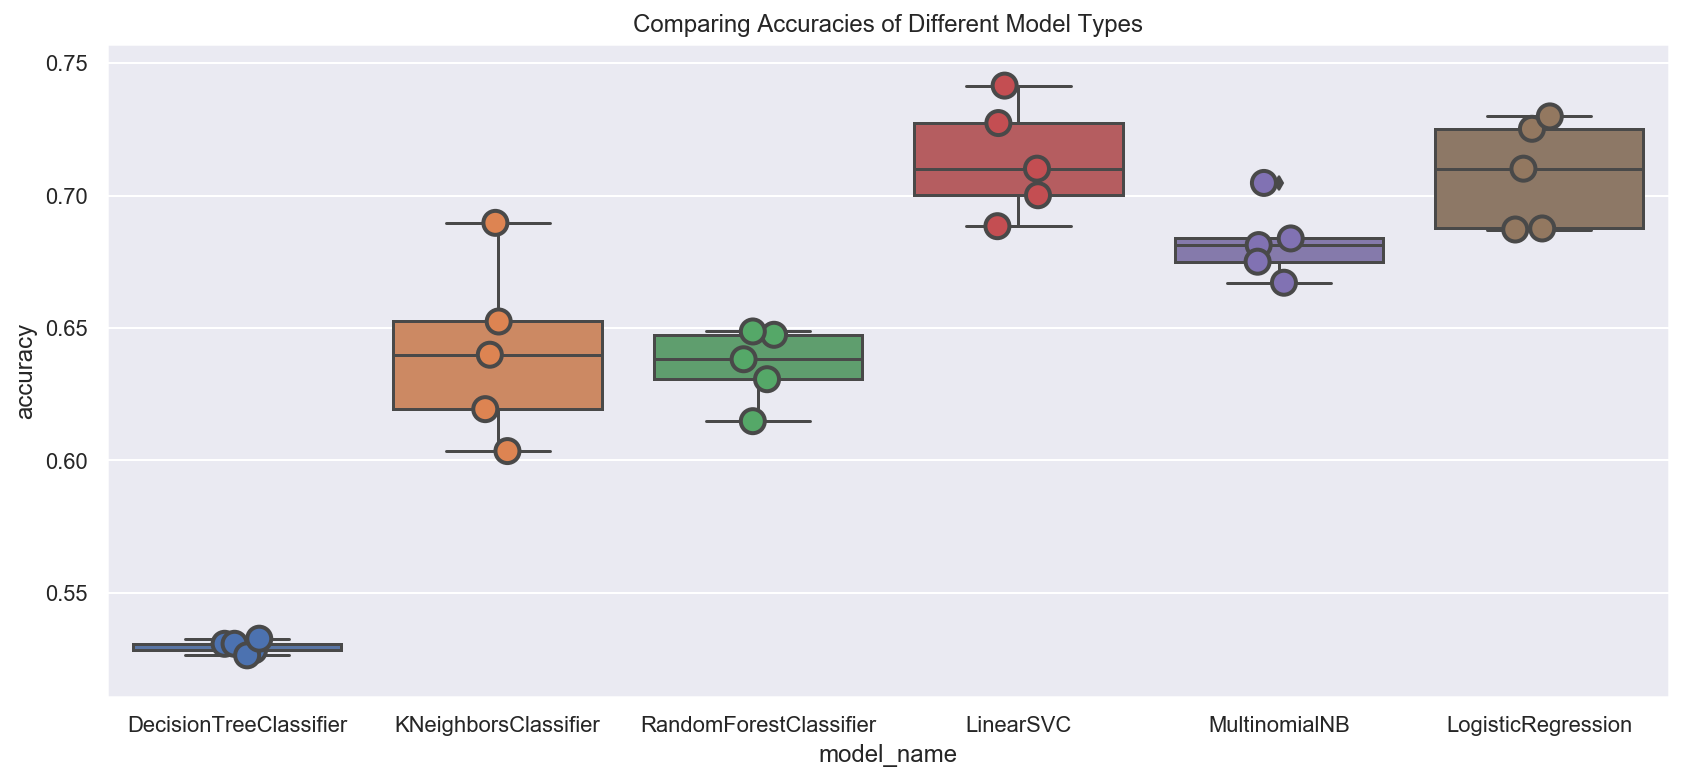

<Figure size 1152x432 with 0 Axes>

In [92]:
import seaborn as sns

sns.set(rc={'figure.figsize':(14,6)})

sns.boxplot(x='model_name', y='accuracy', data=cv_df, width=0.8).set_title('Comparing Accuracies of Different Model Types')
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.figure(figsize=(16, 6))
#plt.set_size_inches(18.5, 10.5)
plt.savefig('test2png.png', dpi=100)
plt.show()


In [93]:
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier   0.53
KNeighborsClassifier     0.64
LinearSVC                0.71
LogisticRegression       0.71
MultinomialNB            0.68
RandomForestClassifier   0.64
Name: accuracy, dtype: float64

## Observation:

My first attempts at Ensembling yielded pretty dubious results. More dubious than some of these standalone models. Looking at this graphs helps explain why - the code I was originally using for Ensemble Methods used Decision Tree and K-Nearest-Neighbour. This graph suggests that these models perform poorly compared to SVC, NB, etc. Which gives us something to go on, in our quest to make the Ensemble Methods produce better results - Ensemble more powerful models!

# ====================================

# LinearSVC (<i>Support Vector Classifier</i>) Model

Split into training and test sets, train model on training set, generate predictions on test set.

In [94]:
from sklearn.model_selection import train_test_split

model_svc = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(tv_matrix, df_sm['sentiment'], df_sm.index, test_size=0.33, random_state=0)
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

# Confusion Matrix: LinearSVC

Calculate, and display, true positives, true negatives, false positives, and false negatives.

We'll show both the raw matrix, and a "Heatmap", which looks cool, but doesn't give too much insight with only two labels.

RAW CONFUSION MATRIX 

[[437 206]
 [176 496]] 

Because the heatmap may LOOK cool, but doesn't tell us much, with only two labels 

--------------------

Heatmap of Consfusion Matrix:


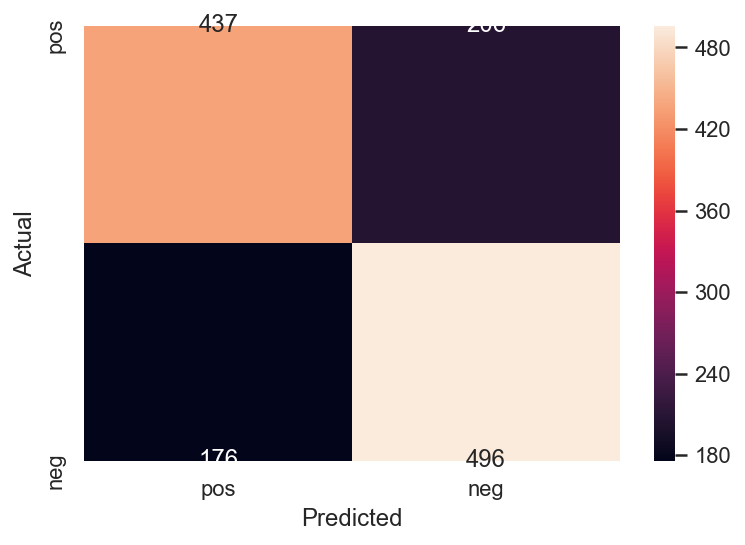

In [95]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print('RAW CONFUSION MATRIX', '\n')
print(conf_mat, '\n')
print('Because the heatmap may LOOK cool, but doesn\'t tell us much, with only two labels \n')
print('--------------------\n')
print('Heatmap of Consfusion Matrix:')
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [96]:
model_svc.fit(tv_matrix, df_sm['sentiment'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Precision, Recall and f1-Score: LinearSVC

In [97]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70       643
           4       0.71      0.74      0.72       672

    accuracy                           0.71      1315
   macro avg       0.71      0.71      0.71      1315
weighted avg       0.71      0.71      0.71      1315



# ROC Curve: LinearSVC

Using code and wisdom from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

A useful tool when predicting the probability of a binary outcome is the <b>Receiver Operating Characteristic curve</b>, or ROC curve.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

No Skill: ROC AUC=0.500
LinearSVC: ROC AUC=0.766

ROC Curve for LinearSVC Classifier:


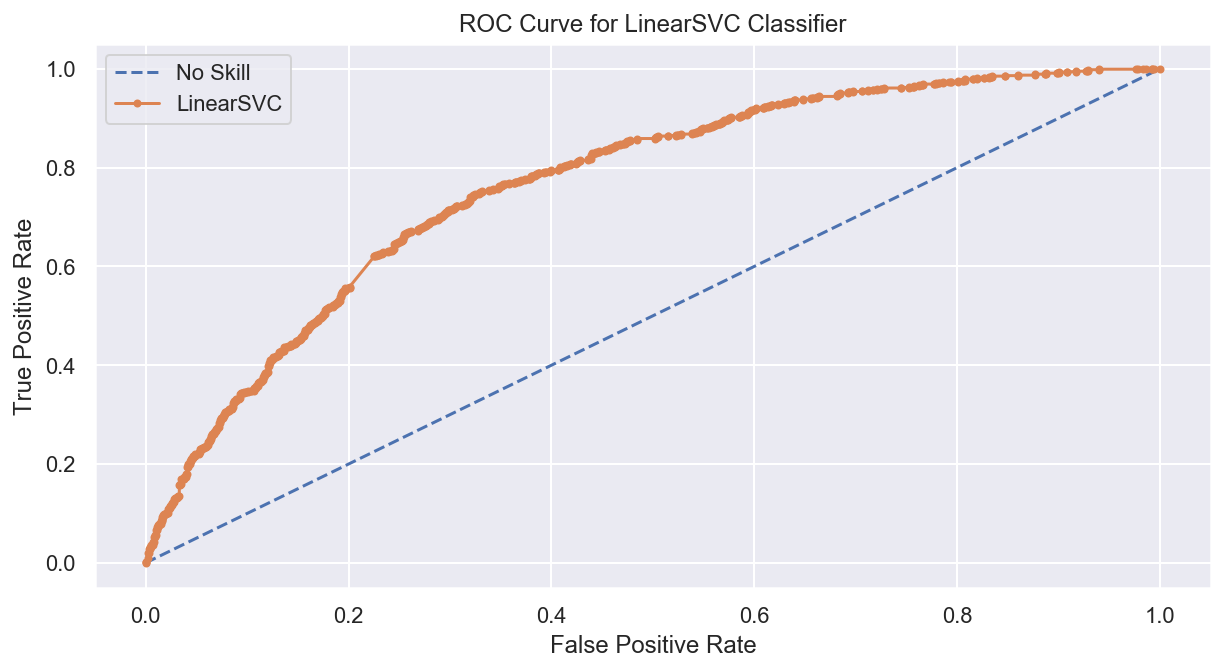

In [98]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# Shrink back our Seaborn graph size - don't need it as big as we had for the accuracy comparison.
sns.set(rc={'figure.figsize':(10,5)})

# generate 2 class dataset
#X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
X = tv_matrix
y = df_sm['sentiment']
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = LogisticRegression(solver='lbfgs')

# We use our model as defined above
model_svc.fit(trainX, trainy)
# predict probabilities
# use _predict_proba_lr(testX) with SVC
lr_probs = model_svc._predict_proba_lr(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LinearSVC: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for LinearSVC Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LinearSVC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for LinearSVC Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

This ROC curve shows considerably higher "skill" than the "no skill" curve, which represents the perfomance of a classifier that just guesses the most likely thing.

# AUC - Area Under the Curve

The "skill" of this model can be represented by the AUC score - the Area Under the Curve - and we do note that despite the LinearSVC model having the highest accuracy and f1-score of the models we tried, Logistic Regression appears to have a higher AUC, as we will see below.

## Precision-Recall Curve: LinearSVC Model

LinearSVC: f1=0.846 auc=0.899


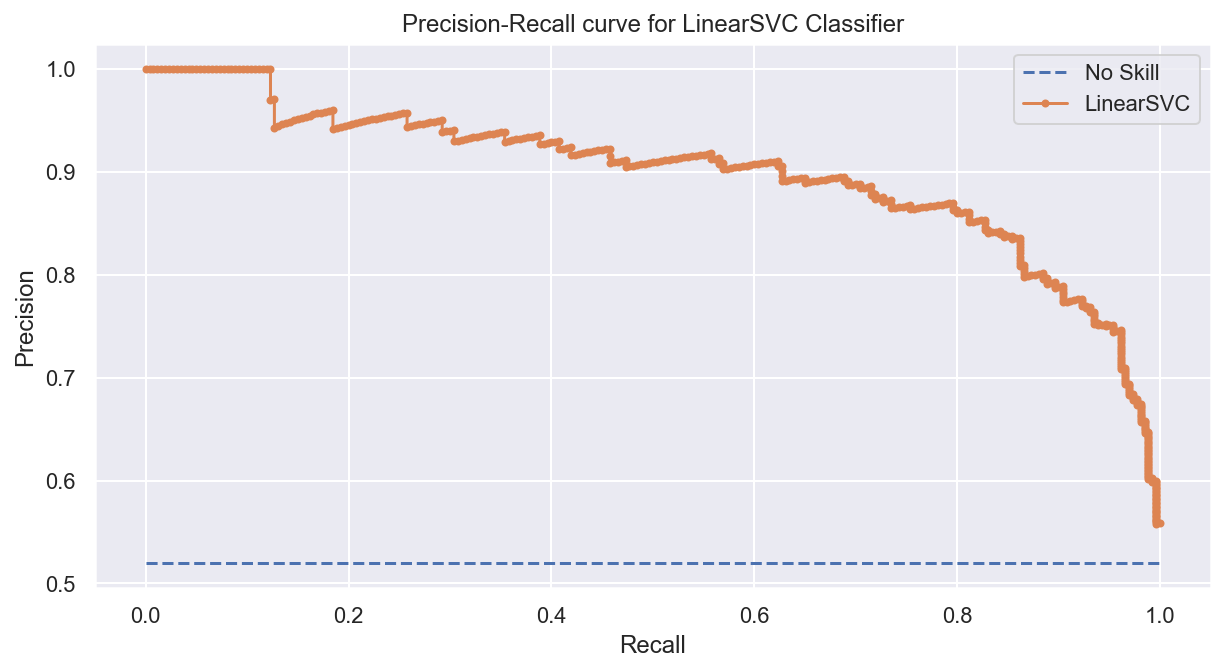

In [99]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
# model = LogisticRegression(solver='lbfgs')

# use our model
model = model_svc

model.fit(trainX, trainy)
# predict probabilities
lr_probs = model._predict_proba_lr(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('LinearSVC: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='LinearSVC')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall curve for LinearSVC Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

The precision-recall curve plot show the precision/recall for each threshold for a Linear Support Vector Classifier model (orange) compared to a no skill model (blue).

## When to Use ROC vs. Precision-Recall Curves?

Again from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Generally, the use of ROC curves and precision-recall curves are as follows:

- ROC curves should be used when there are roughly equal numbers of observations for each class.
- Precision-Recall curves should be used when there is a moderate to large class imbalance.

The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

Some go further and suggest that using a ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill.

The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve.

## As our dataset is very very balanced, we will lean towards ROC.

## Learning Curves: LinearSVC

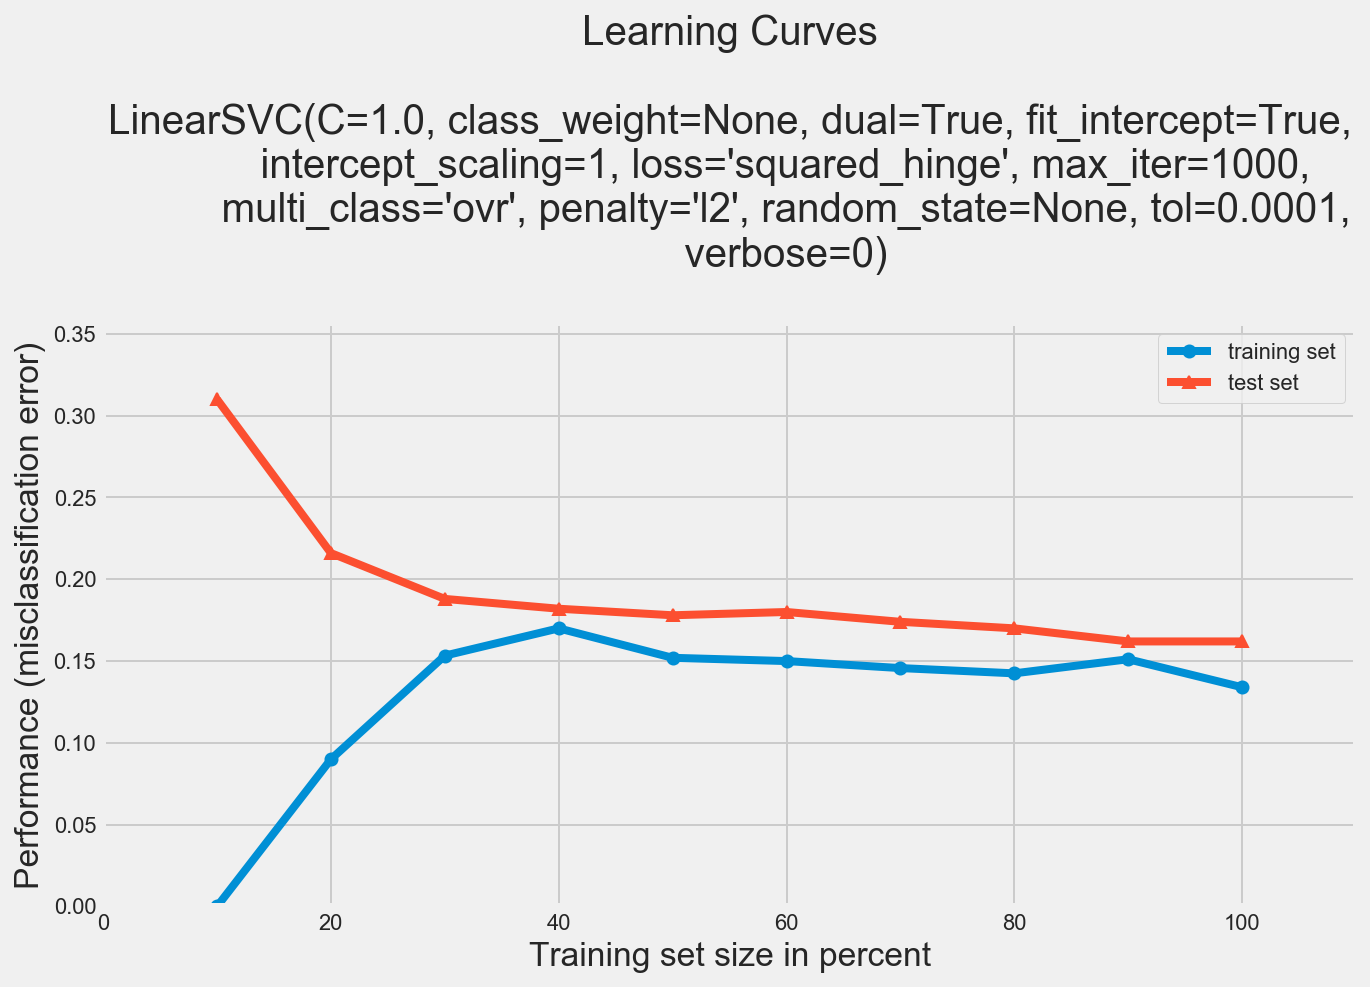

In [100]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_svc)
plt.show()

# ============================

# Logistic Regression

We'll do the same metrics for Logistic Regression as we did for LinearSVC


Confusion Matrix for Logistic Regression Model: 

[[456 187]
 [216 456]] 

Confusion Matrix for Logistic Regression Model as a little heatmap:


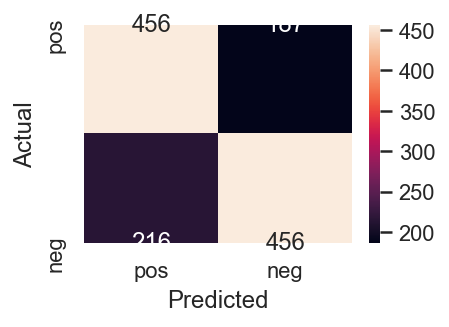


Precision, Recall, F1-scores for Logistic Regression Model: 

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       643
           4       0.71      0.68      0.69       672

    accuracy                           0.69      1315
   macro avg       0.69      0.69      0.69      1315
weighted avg       0.69      0.69      0.69      1315



In [101]:
model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Logistic Regression Model: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Logistic Regression Model as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Logistic Regression Model:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

## ROC Curve: Logistic Regression Classifier

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.766

ROC curve for Logistic Regression Classifier:


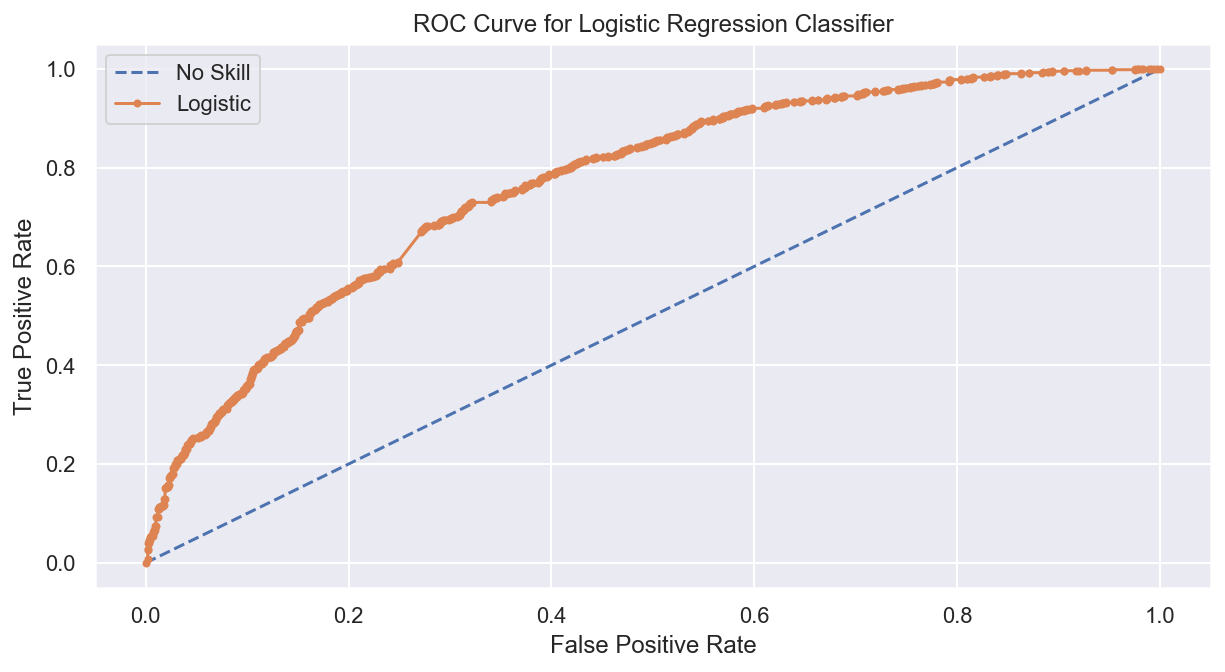

In [102]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_lr

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('\nROC curve for Logistic Regression Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Logistic Regression Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Precision-Recall Curve: Logistic Regression

Logistic Regression: f1=0.841 auc=0.898


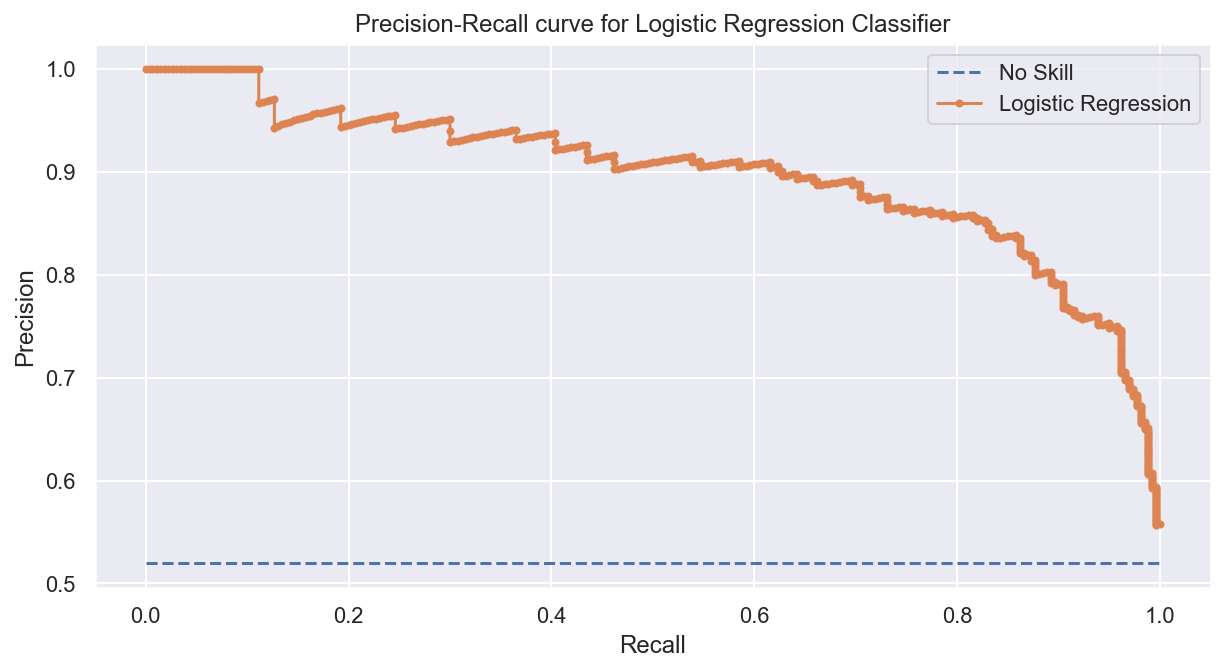

In [103]:
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
# model = LogisticRegression(solver='lbfgs')

# use our model
model = model_lr

model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic Regression: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall curve for Logistic Regression Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curves: Logistic Regression

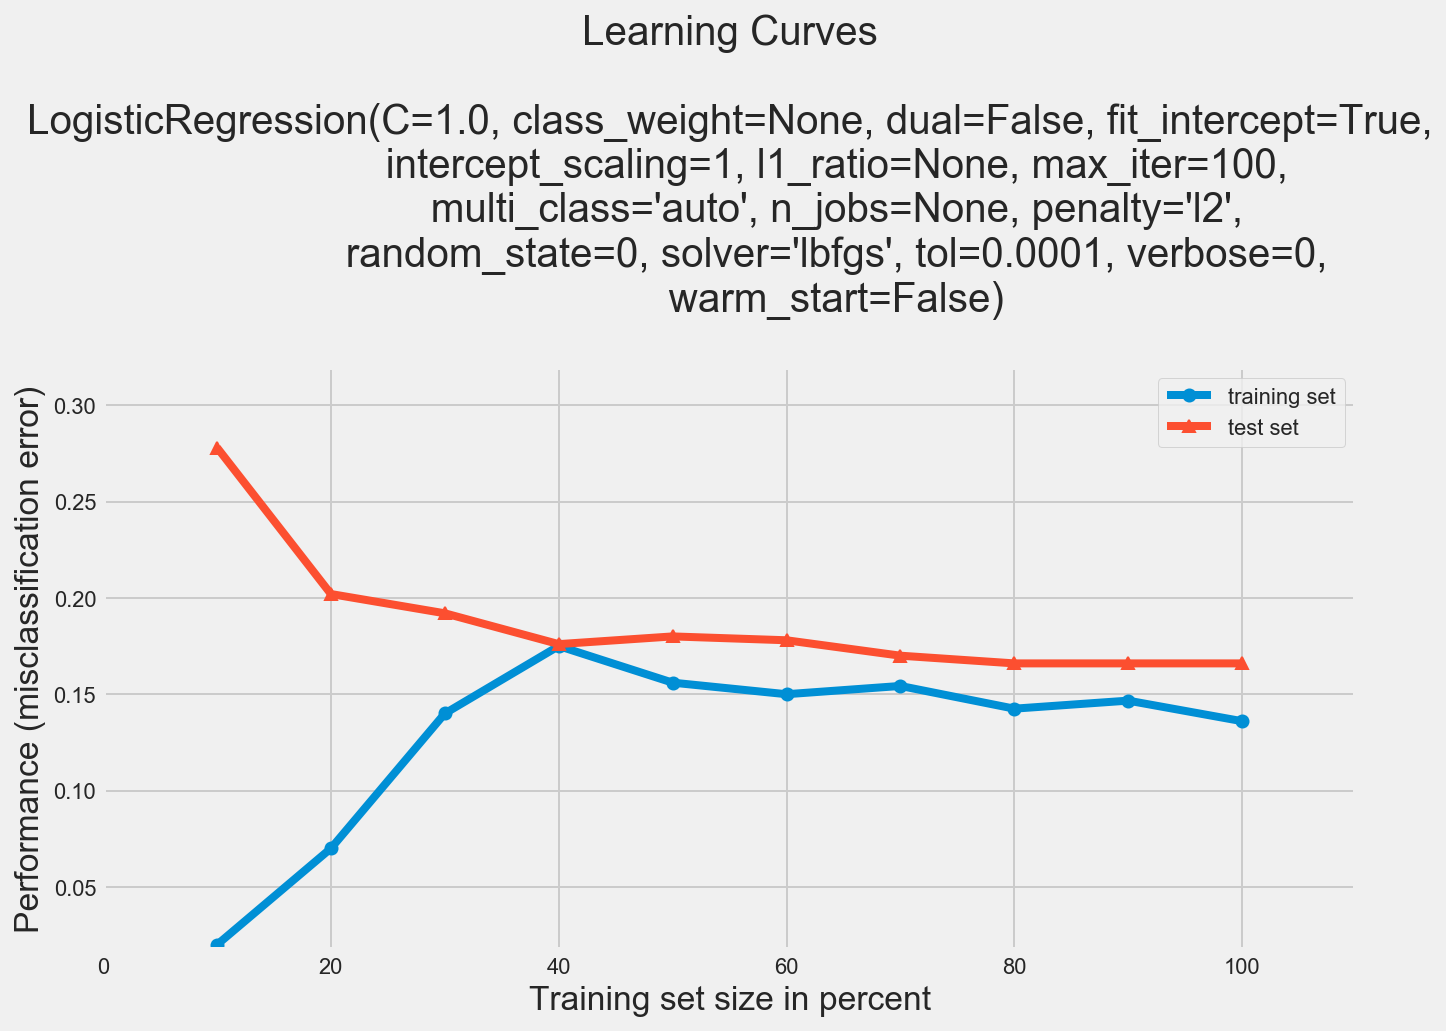

In [104]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_lr)
plt.show()

# ===========================

# Multinomial NB Classifier

The <b>Multinomial Naive Bayes classifier</b> is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.


Confusion Matrix for Multinomial Naive Bayes Classifier: 

[[456 187]
 [241 431]] 

Confusion Matrix for Multinomial Naive Bayes Classifier as a little heatmap:


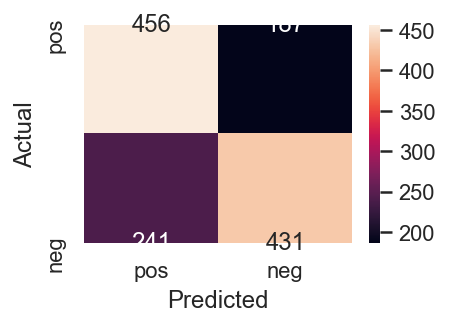


Precision, Recall, F1-scores for Multinomial Naive Bayes Classifier: 

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       643
           4       0.70      0.64      0.67       672

    accuracy                           0.67      1315
   macro avg       0.68      0.68      0.67      1315
weighted avg       0.68      0.67      0.67      1315



In [105]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred = model_mnb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Multinomial Naive Bayes Classifier: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Multinomial Naive Bayes Classifier as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Multinomial Naive Bayes Classifier:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

# ROC and AUC: MultinomialNB

As with above.

No Skill: ROC AUC=0.500
MultinomialNB: ROC AUC=0.760

ROC Curve for MultinomialNB:


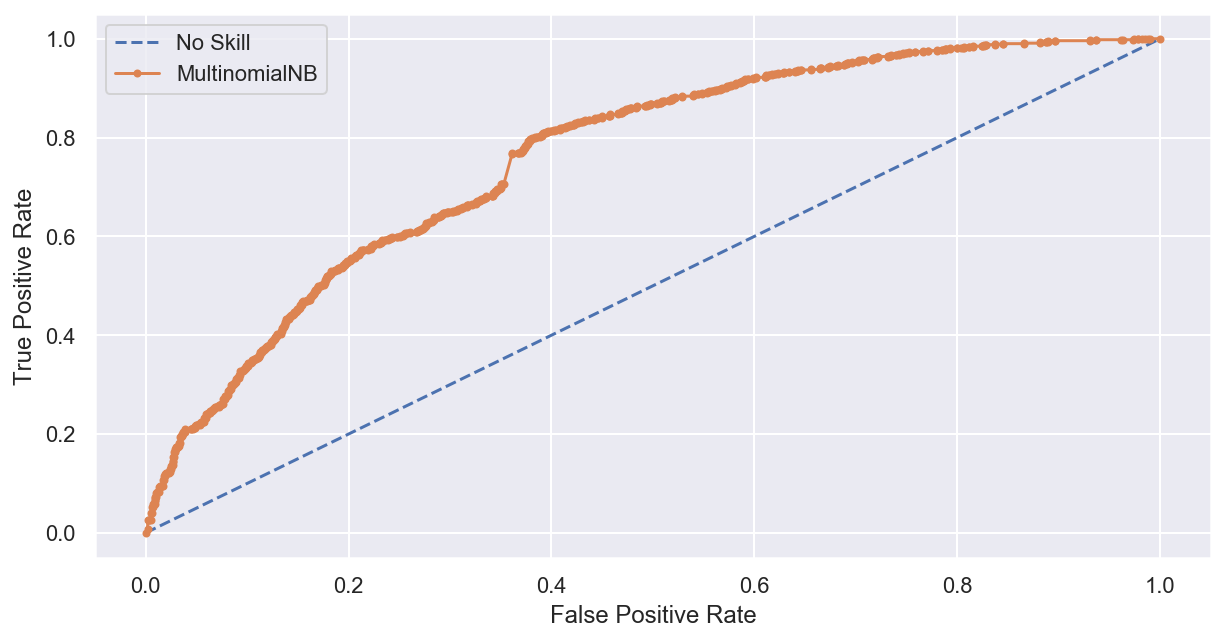

In [106]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_mnb

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('MultinomialNB: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for MultinomialNB:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='MultinomialNB')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curves: MultinomialNB

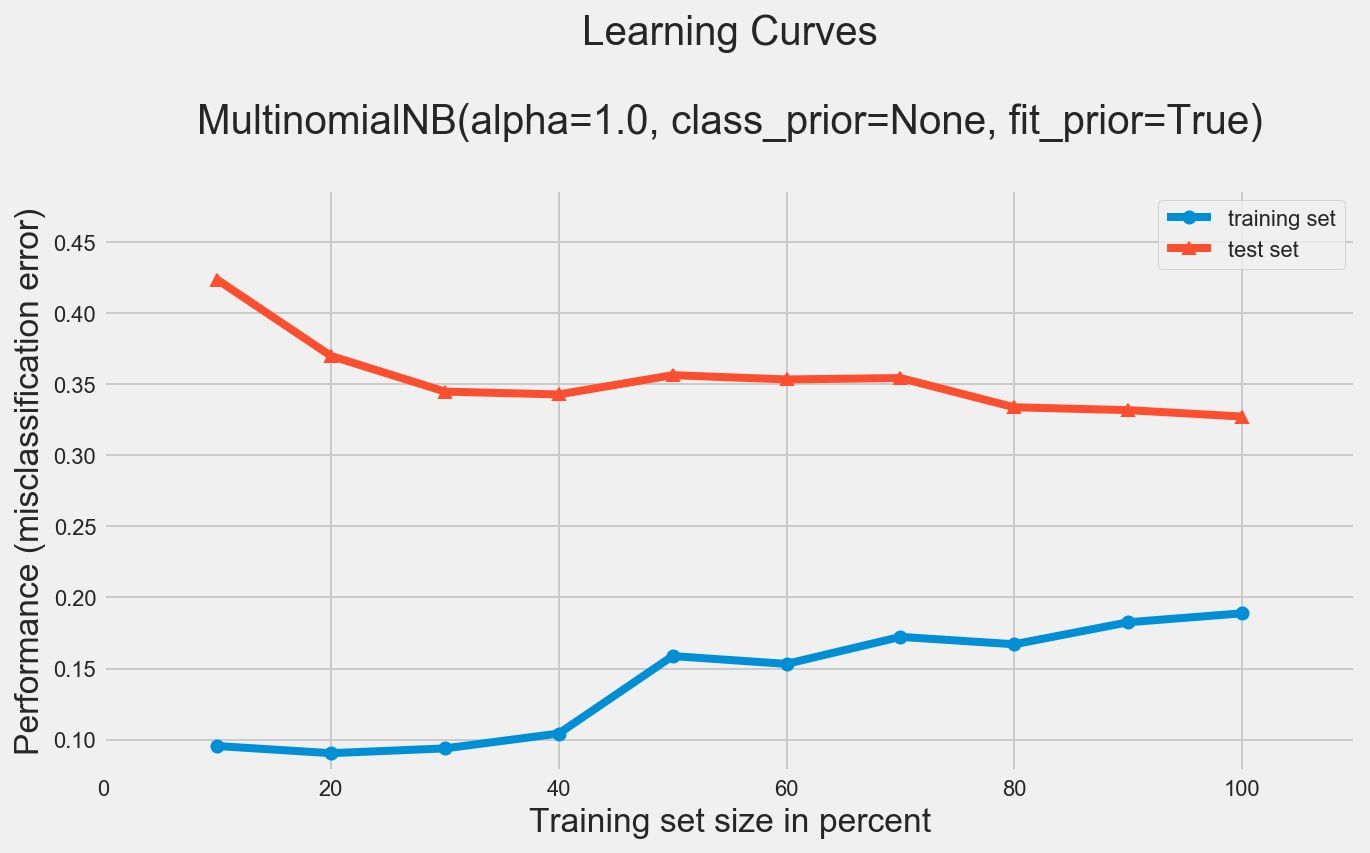

In [107]:

plot_learning_curves(trainX, trainy, testX, testy, model_mnb)
plt.show()

# ===============================================

# Random Forest Classifier

It did perform poorly on the "accuracy" comparison, especially with the really small dataset, but as we've seen above, accuracy is a poor predictor of other performance measures.


Confusion Matrix for Random Forest Classifier: 

[[491 152]
 [324 348]] 

Confusion Matrix for Random Forest Classifier as a little heatmap:


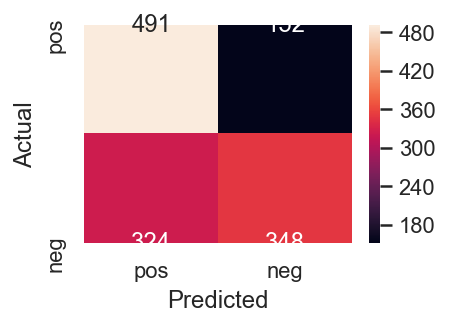


Precision, Recall, F1-scores for Random Forest Classifier Classifier: 

              precision    recall  f1-score   support

           0       0.60      0.76      0.67       643
           4       0.70      0.52      0.59       672

    accuracy                           0.64      1315
   macro avg       0.65      0.64      0.63      1315
weighted avg       0.65      0.64      0.63      1315



In [108]:
model_rfc = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
#model_mnb = MultinomialNB()
model_rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Random Forest Classifier: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Random Forest Classifier as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Random Forest Classifier Classifier:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

Okay! That is our worst one so far, both in terms of accuracy AND f1-score. Let's do the ROC curve!

## ROC Curve and AUC metric: Random Forest

No Skill: ROC AUC=0.500
Random Forest Classifier: ROC AUC=0.726

ROC Curve for Random Forest Classifier:


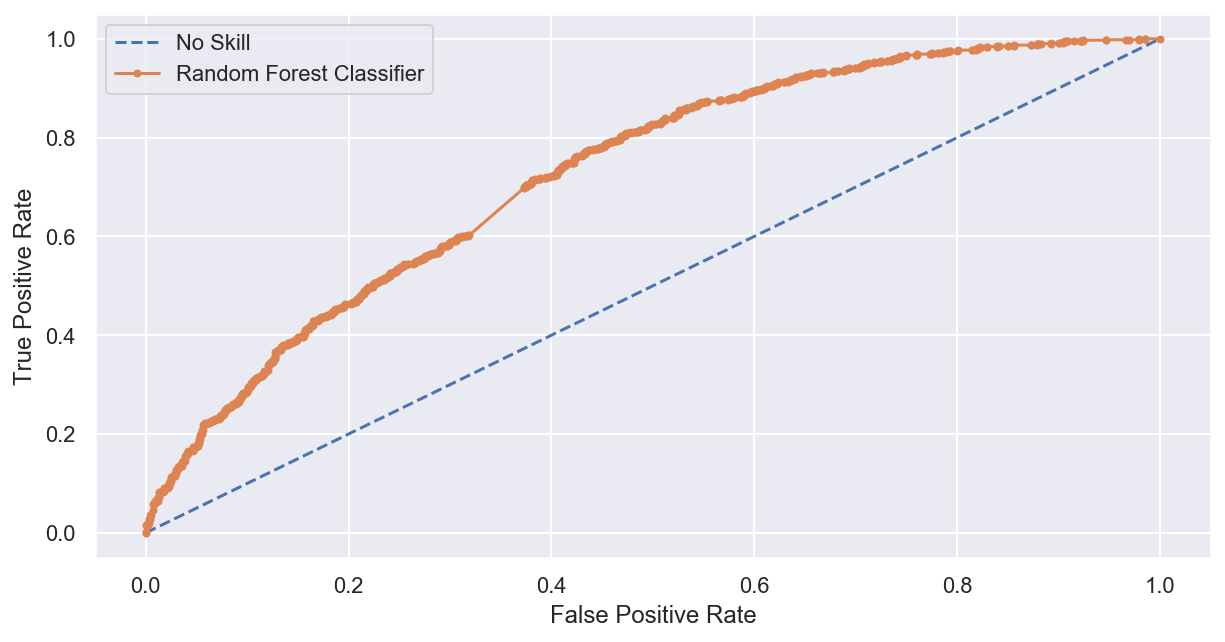

In [109]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_rfc

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest Classifier: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for Random Forest Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest Classifier')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curve: Random Forest

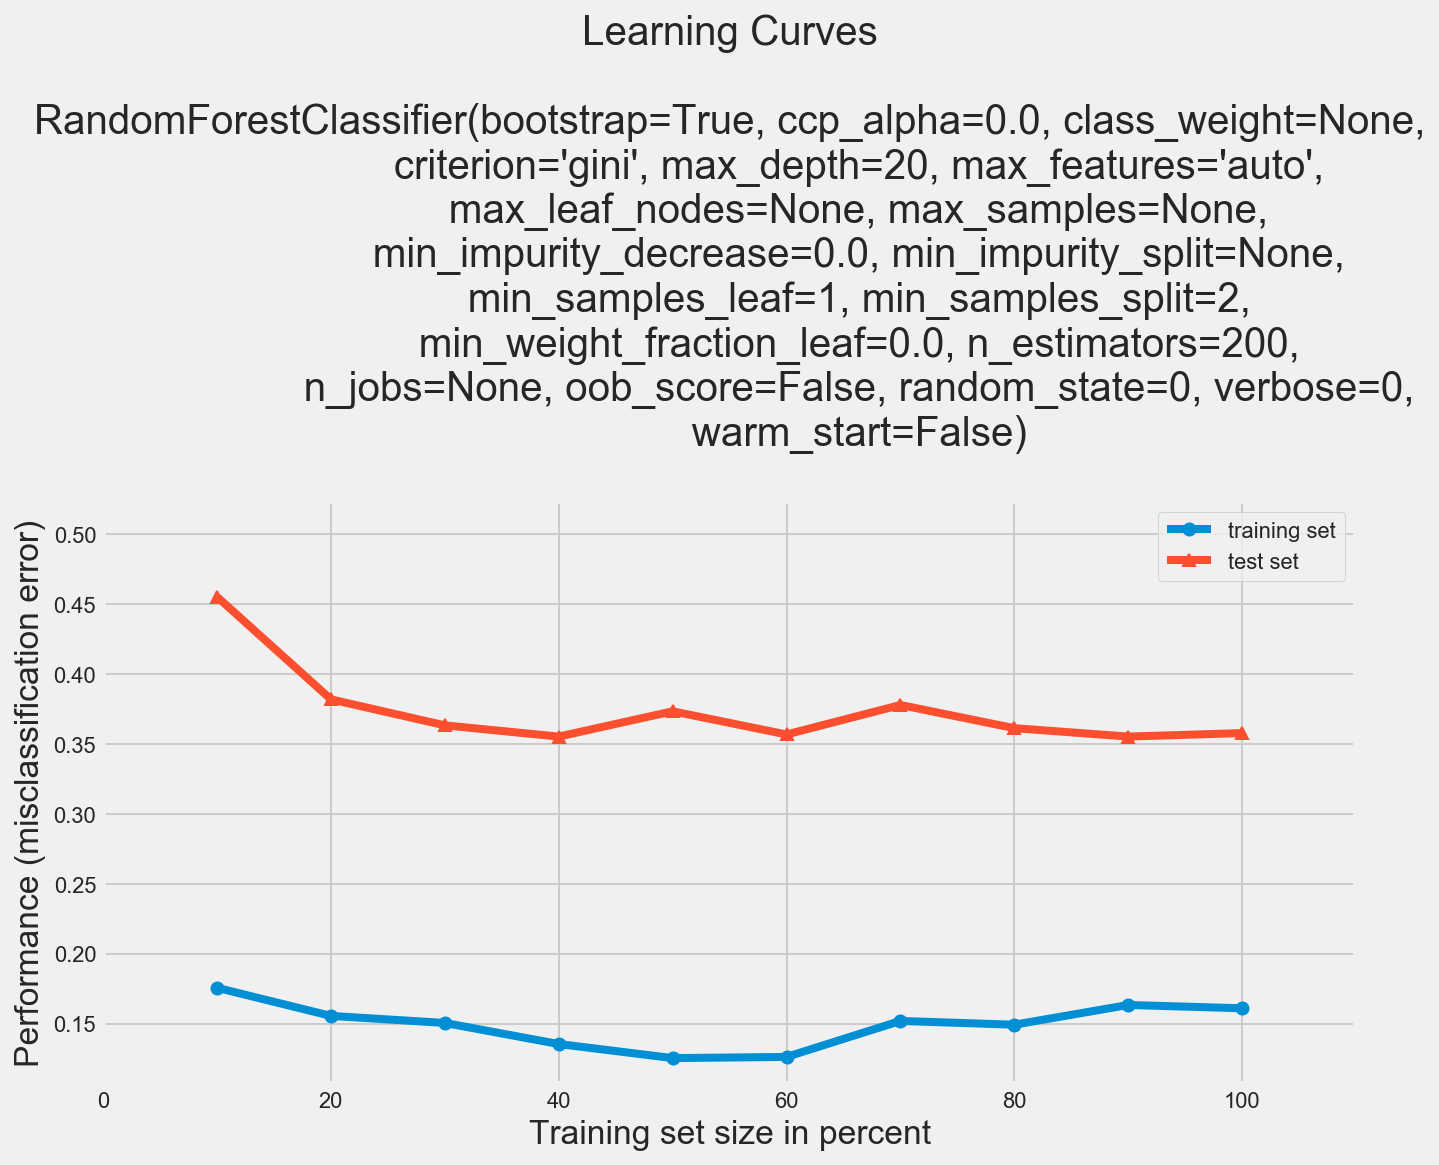

In [110]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_rfc)
plt.show()

## Interesting points of comparison!!

Early in this project, I was doing sentiment predictions with Afinn, to be used as a baseline later. At our first arrival at this point, things are looking better already!

#### Weighted Avg F1-Scores
-----------------------------------

0.63 - Afinn original values.

0.70 - Logistic Regression, 800 rows total, Tf-idf encoding

0.74 - LinearSVC, 800 rows total, Tf-idf encoding


# ============================

# Ensembling

# ============================

Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking). Ensemble methods can be divided into two groups: sequential ensemble methods where the base learners are generated sequentially (e.g. AdaBoost) and parallel ensemble methods where the base learners are generated in parallel (e.g. Random Forest). The basic motivation of sequential methods is to exploit the dependence between the base learners since the overall performance can be boosted by weighing previously mislabeled examples with higher weight. The basic motivation of parallel methods is to exploit independence between the base learners since the error can be reduced dramatically by averaging.

Most ensemble methods use a single base learning algorithm to produce homogeneous base learners, i.e. learners of the same type leading to homogeneous ensembles. There are also some methods that use heterogeneous learners, i.e. learners of different types, leading to heterogeneous ensembles. In order for ensemble methods to be more accurate than any of its individual members the base learners have to be as accurate as possible and as diverse as possible.

### Bagging

Bagging stands for <b>bootstrap aggregation</b>. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble:

\begin{equation}
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
\end{equation}

<b>Translation:</b> <i><u>The final result is the average of the M sub-results.</u></i>

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.

In [111]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

## In the coding example used for this section of the project, ensemble methods are used on Decision Tree Classifiers and K Nearest Neighbour Classifiers.

As we saw in our comparison on standalone models, these are the two worst, of the six we tried. We will instead use Logistic Regression and a Linear Support Vector Classifier for our Ensemble Methods.

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [113]:
# X, y = iris.data[:, 0:2], iris.target

X = tv_matrix
y = np.array(df_sm['sentiment'])
    
clf1 = LogisticRegression(random_state=0)
clf2 = LinearSVC()   

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

Accuracy: 0.70 (+/- 0.01) [Logistic Regression]
Accuracy: 0.70 (+/- 0.01) [LinearSVC]
Accuracy: 0.68 (+/- 0.01) [Bagging Regression]
Accuracy: 0.69 (+/- 0.01) [Bagging SVC]


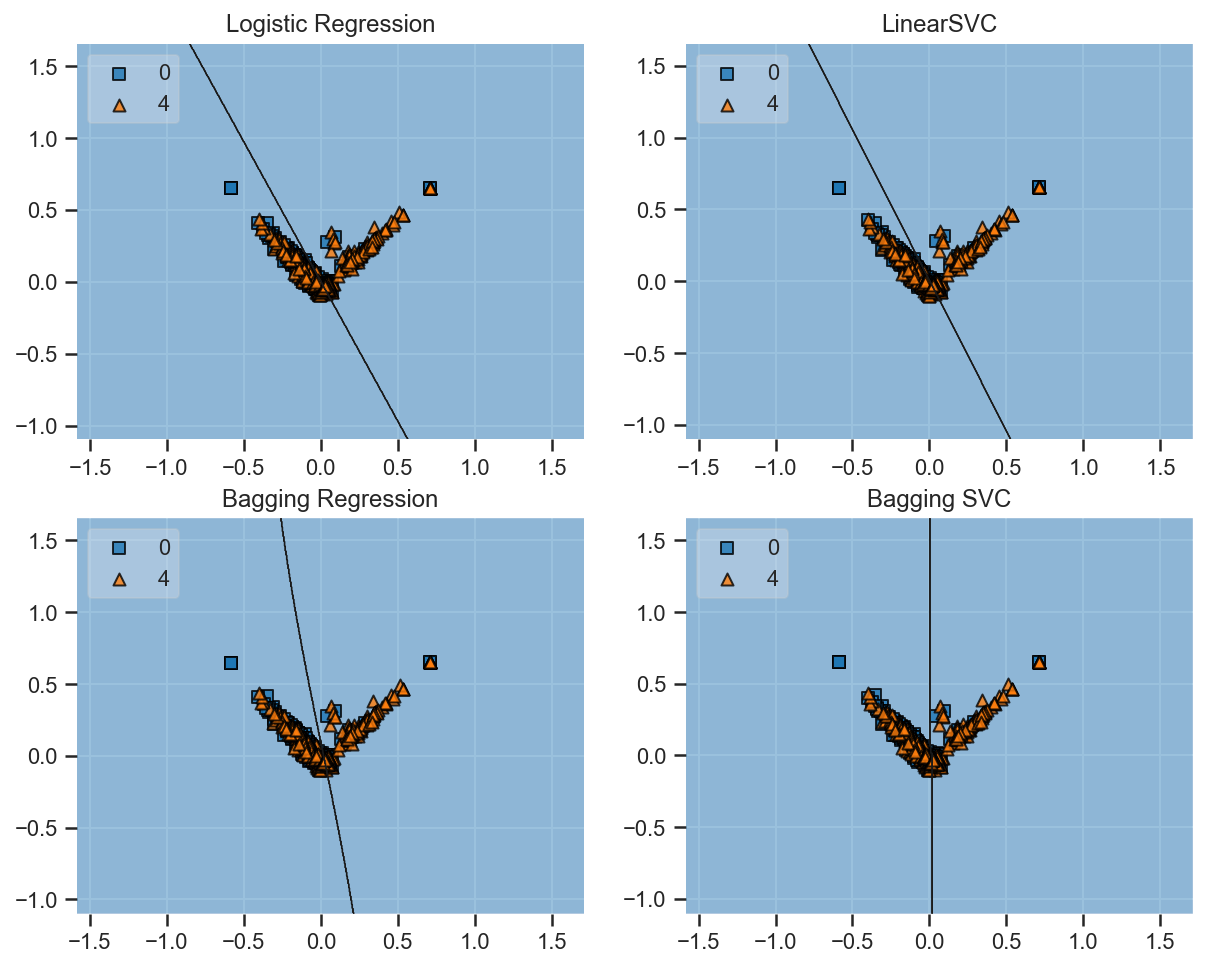

In [114]:
from sklearn.decomposition import PCA

label = ['Logistic Regression', 'LinearSVC', 'Bagging Regression', 'Bagging SVC']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    
    
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    #clf.fit(X, y)
    
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
    #clf.fit(X_flattened, y)
    #clf.fit(X, y)
    clf.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=clf, legend=2)
    plt.title(label)
    

    #plot_decision_regions(X_train2, y_train, clf=clf, legend=2)

plt.show()

## Much better accuracy with these algorithms! Moved us from the low 60s to the mid 70s.

The figure above shows the decision boundary of a decision tree and k-NN classifiers along with their bagging ensembles applied to the Iris dataset. The decision tree shows axes parallel boundaries while the $k=1$ nearest neighbors fits closely to the data points. The bagging ensembles were trained using $10$ base estimators with $0.8$ subsampling of training data and $0.8$ subsampling of features. The decision tree bagging ensemble achieved higher accuracy in comparison to k-NN bagging ensemble because k-NN are less sensitive to perturbation on training samples and therefore they are called *stable learners*. Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

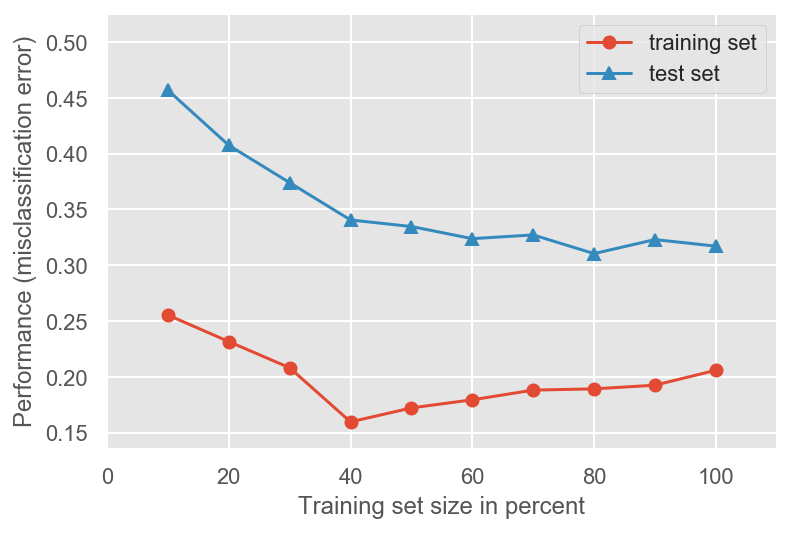

In [115]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

The figure above shows learning curves for the bagging tree ensemble. We can see an average error of  0.35  on the training data and a U-shaped error curve for the testing data. The smallest gap between training and test errors occurs at around  80%  of the training set size.

In [116]:
#Ensemble Size
# num_est = map(int, np.linspace(1,100,20))
num_est = np.linspace(1,50,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

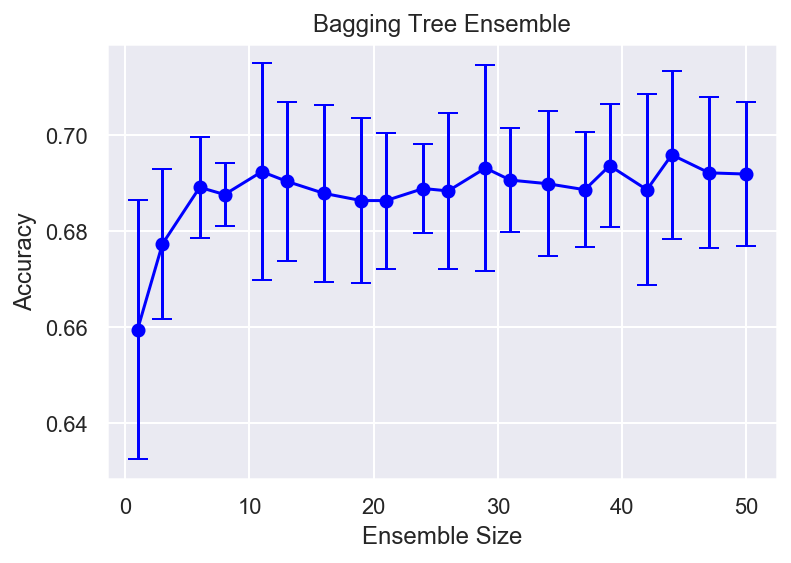

In [117]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
# caps = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble. Based on cross-validation results, we can see the accuracy increases until approximately $20$ base estimators and then plateaus afterwards. Thus, adding base estimators beyond $20$ only increases computational complexity without accuracy gains for the Sentiment140 dataset.

----------------------

## Boosting

Boosting refers to a family of algorithms that are able to convert weak learners to strong learners. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing, such as small decision trees) to weighted versions of the data, where more weight is given to examples that were mis-classified by earlier rounds. The predictions are then combined through a weighted majority vote (classification) or a weighted sum (regression) to produce the final prediction. The principal difference between boosting and the committee methods such as bagging is that base learners are trained in sequence on a weighted version of the data.

In [118]:
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [119]:
X = tv_matrix
y = np.array(df_sm['sentiment'])

clf = LogisticRegression(random_state=0)

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

In [120]:
len(X)

3983

Accuracy: 0.70 (+/- 0.01) [AdaBoost (n_est=1)]
Accuracy: 0.70 (+/- 0.01) [AdaBoost (n_est=2)]
Accuracy: 0.70 (+/- 0.01) [AdaBoost (n_est=3)]
Accuracy: 0.70 (+/- 0.01) [AdaBoost (n_est=10)]


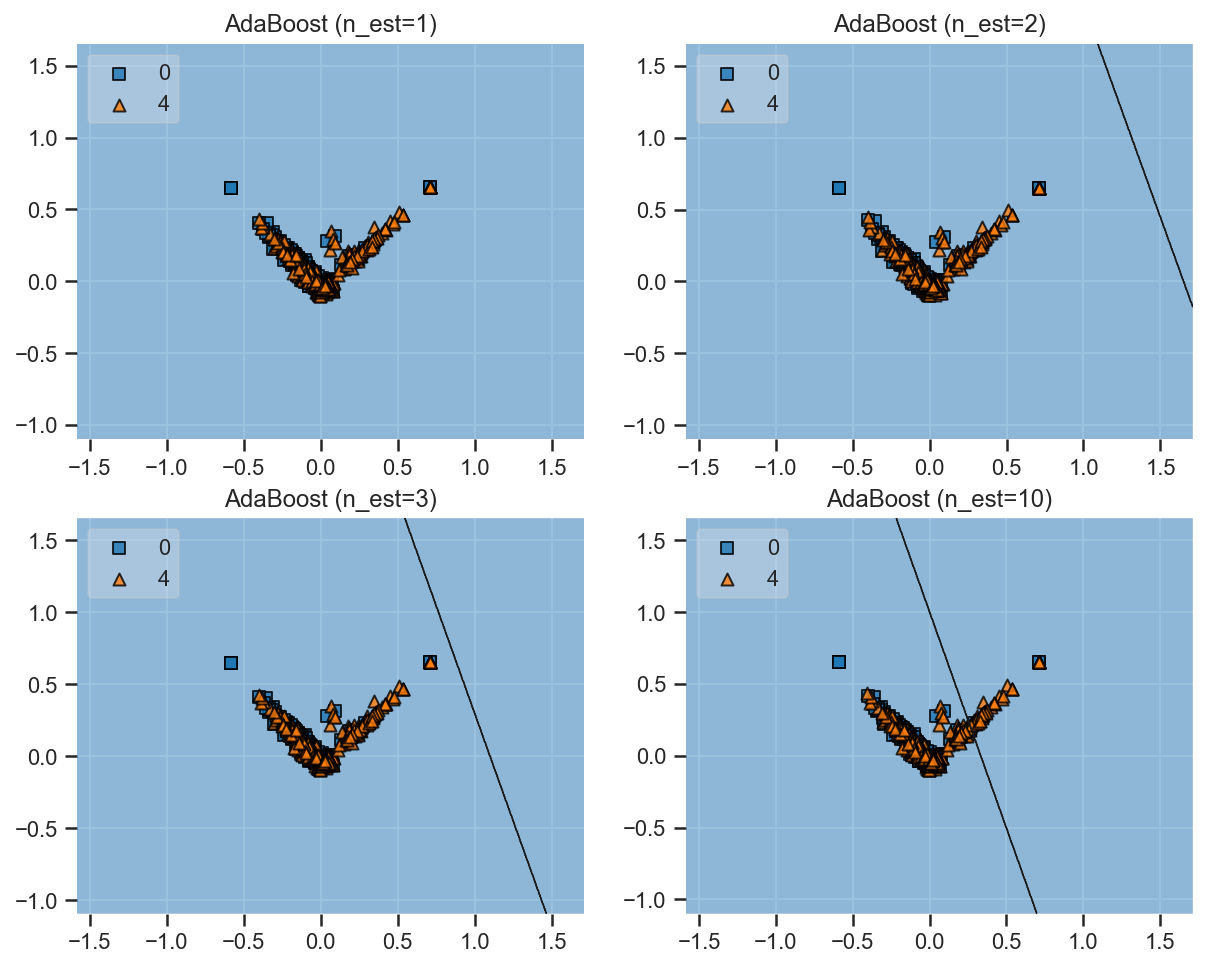

In [121]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    
    
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
    boosting.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

The AdaBoost algorithm is illustrated in the figure above. Each base learner consists of a decision tree with depth $1$, thus classifying the data based on a feature threshold that partitions the space into two regions separated by a linear decision surface that is parallel to one of the axes.

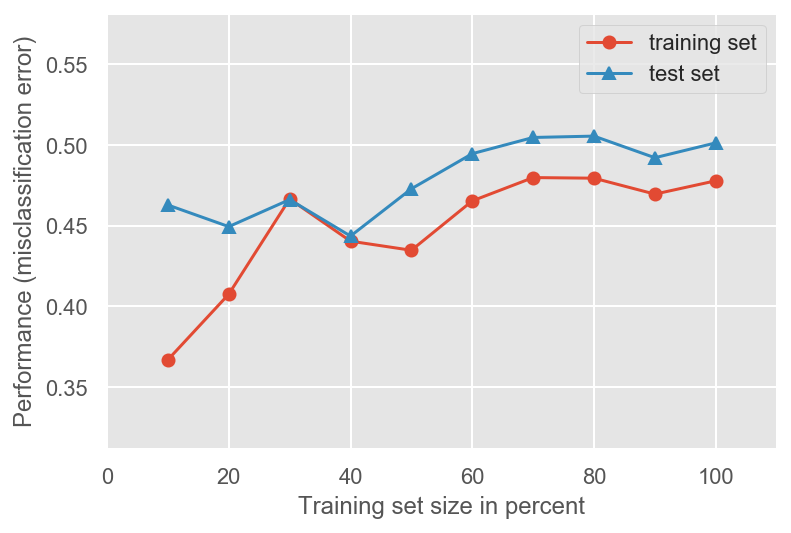

In [122]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=20)
        
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

In [123]:
#Ensemble Size
#num_est = map(int, np.linspace(1,100,20))
num_est = np.linspace(1,200,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

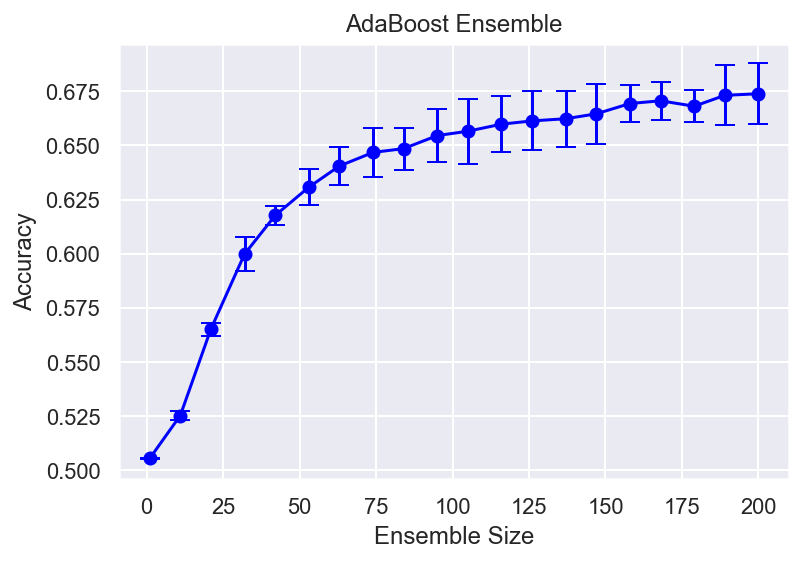

In [124]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

----------------

## Stacking

Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

In [125]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [126]:
X = tv_matrix
y = np.array(df_sm['sentiment'])

clf1 = LogisticRegression(random_state=0)
clf2 = LinearSVC()  
#clf1 = KNeighborsClassifier(n_neighbors=1)
#clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

Accuracy: 0.58 (+/- 0.01) [Logistic Regression]
Accuracy: 0.58 (+/- 0.01) [LinearSVC]
Accuracy: 0.52 (+/- 0.00) [Naive Bayes]
Accuracy: 0.57 (+/- 0.01) [Stacking Classifier]


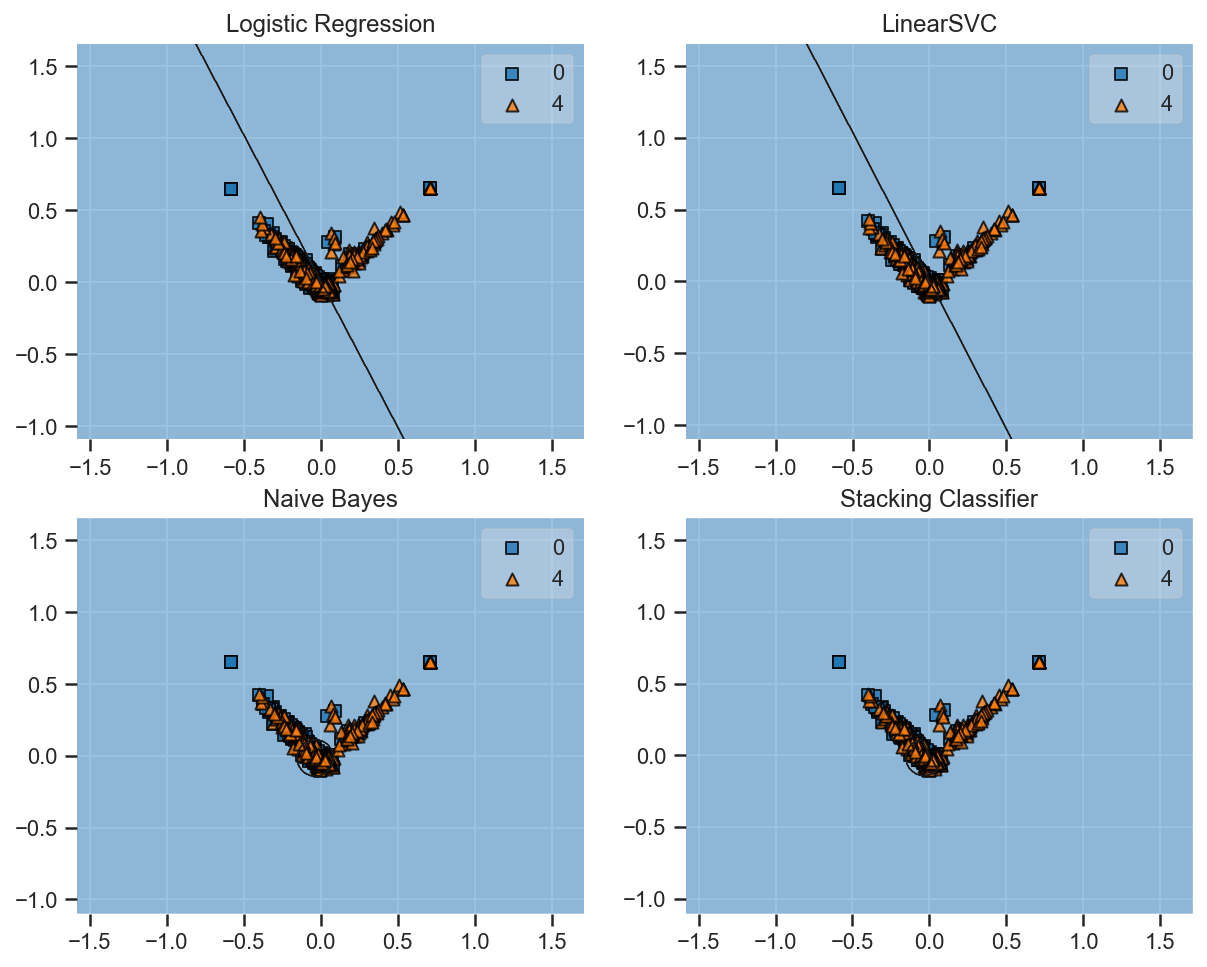

In [127]:
label = ['Logistic Regression', 'LinearSVC', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
    
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
        
    scores = cross_val_score(clf, X_flattened, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=clf)
    plt.title(label)

plt.show()

The stacking ensemble is illustrated in the figure above. It consists of k-NN, Random Forest and Naive Bayes base classifiers whose predictions are combined by Lostic Regression as a meta-classifier. We can see the blending of decision boundaries achieved by the stacking classifier.

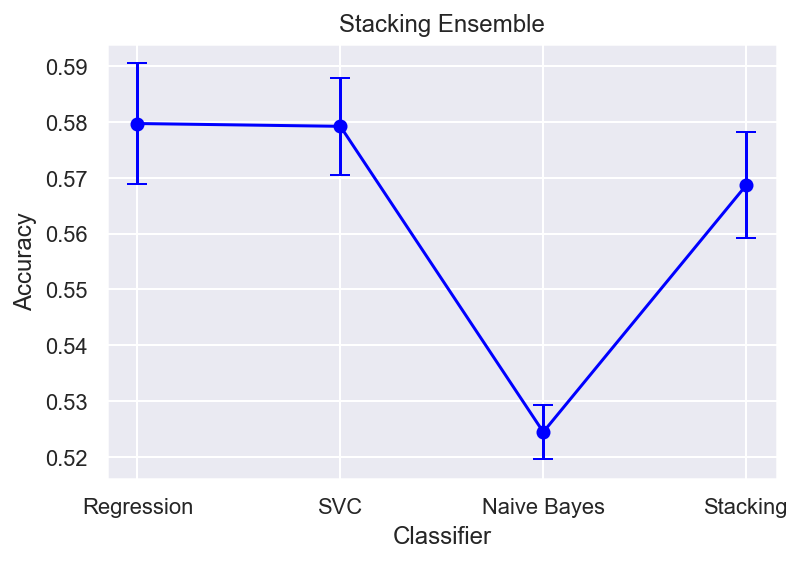

In [128]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['Regression', 'SVC', 'Naive Bayes', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

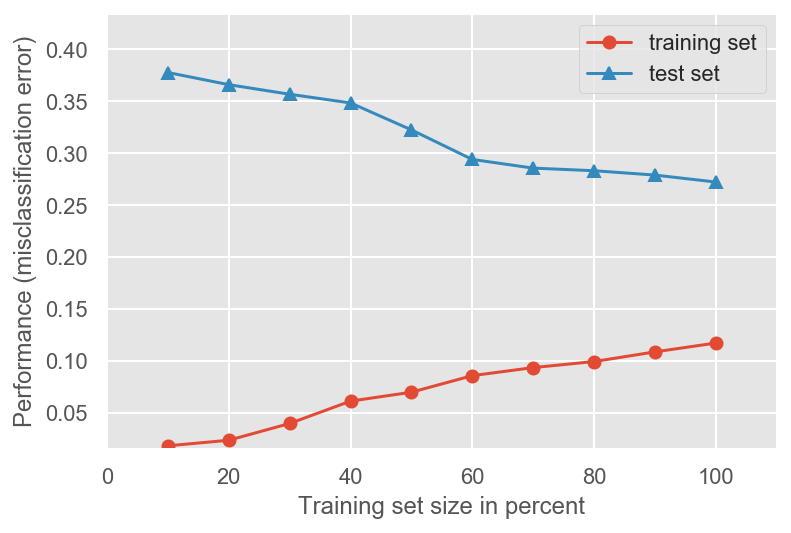

In [129]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
plt.show()

End of code for Milestone 2. Please see top of document for more information.

---------------------

-----------------------

-----------------------

----------------------

----------------------

---------------------
#
#
#
### End of working working file.
#
#
#

## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [130]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [131]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [132]:
#for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
#    print('TEXT:', texts)
#    print('Actual Sentiment:', sentiment)
#    print('Predicted Sentiment polarity:', afn.score(texts))
#    print('-'*60)

In [133]:
# Predict sentiment with Afinn

#sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
#predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [134]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
#meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
#                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [135]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
1105578,4,1971306796,Sat May 30 06:46:55 PDT 2009,NO_QUERY,lizziepatrick,"oi oi everyone hope your all good and having a fab day, i think i need more Tweet followers haha so get your mates adding me please","oi oi everyone hope your all good and having a fab day, i think i need more Tweet followers haha so get your mates adding me please",oi oi everyone hope good fab day think need tweet followers haha get mates adding please,oi oi everyone hope good fab day think need tweet follower haha get mate add please,oi oi good fab day follower mate,tweet,hope think need get add,oi oi good fab day follower mate tweet hope think need get add,16
638620,0,2234505679,Thu Jun 18 23:10:59 PDT 2009,NO_QUERY,gr8rahul,negative inflation ... no wonder my pay cut is being justified,negative inflation ... no wonder my pay cut is being justified,negative inflation . wonder pay cut justified,negative inflation . wonder pay cut justify,inflation wonder pay cut,negative,justify,inflation wonder pay cut negative justify,7
239770,0,1980693852,Sun May 31 07:25:59 PDT 2009,NO_QUERY,Lady_Saga,Had to mow lawn yesterday with a push mower. I can finally feel my fingertips now. Didn't get a chance to play anything yesterday,Had to mow lawn yesterday with a push mower. I can finally feel my fingertips now. Didn't get a chance to play anything yesterday,mow lawn yesterday push mower finally feel fingertips ' get chance play anything yesterday,mow lawn yesterday push mower finally feel fingertip ' get chance play anything yesterday,mow lawn yesterday mower fingertip chance yesterday,,push feel play,mow lawn yesterday mower fingertip chance yesterday push feel play,14
48377,0,1677856131,Sat May 02 04:21:10 PDT 2009,NO_QUERY,manicmuso,@theatrix OMG!! Well done u!! I'm still battling away at level 19,OMG!! Well done u!! I'm still battling away at level,omg well done u !! ' still battling away level,omg well do u ! ! ' still battle away level,u level,,omg do battle,u level omg do battle,11
1491973,4,2069195688,Sun Jun 07 15:26:11 PDT 2009,NO_QUERY,LisaKCarter,"@jenzavala YAY! I'm going to bed, but I will definitely read them tomorrow during my long break at school. I'm excited!","YAY! I'm going to bed, but I will definitely read them tomorrow during my long break at school. I'm excited!","yay im going bed , definitely read tomorrow long break school . ' excited !","yay -PRON- be go bed , definitely read tomorrow long break school . ' excited !",yay bed tomorrow break school,long excited,be go read,yay bed tomorrow break school long excited be go read,16


## Save to database

In [136]:
#df.to_sql('df_sm', con)